# Seed


In [ ]:
from numpy.random import seed
seed(3)

# Import de fonctions

In [ ]:
import matplotlib.pyplot as plt
import sklearn
from sklearn.metrics import adjusted_rand_score as ARI
from sklearn.metrics import adjusted_mutual_info_score as AMI
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import v_measure_score
from skimage.transform import resize
from sklearn.mixture import GaussianMixture
from scipy.stats import wasserstein_distance
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import numpy as np
import datetime
import torch
import sys
from scipy.special import logsumexp
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.lines import Line2D
from torch.optim.lr_scheduler import StepLR
from matplotlib.patches import Patch
from sklearn.preprocessing import normalize
!pip install umap-learn
import umap
from sklearn.manifold import TSNE
import plotly.express as px

# Dataset des chiffres du MNIST
from keras.datasets import mnist

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.9/90.9 kB 3.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.8/55.8 kB 8.4 MB/s eta 0:00:00
  Created wheel for umap-learn: filename=umap_learn-0.5.5-py3-none-any.whl size=86832 sha256=183de8a1d0d0a6b22cb78a63ecd1d5d432d43f6d0ed671a2d346848b9a0f5044
  Stored in directory: /root/.cache/pip/wheels/3a/70/07/428d2b58660a1a3b431db59b806a10da736612ebbc66c1bcc5
Successfully built umap-learn


In [ ]:
@torch.no_grad()
class SoftSKKMeans:
    '''
    Soft Sinkhorn-Knopp Kmeans clustering algorithm implemented with PyTorch
    Parameters:
      n_clusters: int,
        Number of clusters
      max_iter: int, default: 100
        Maximum number of iterations
      tol: float, default: 0.0001
        Tolerance

      mode: {'euclidean', 'cosine'}, default: 'euclidean'
        Type of distance measure
      minibatch: {None, int}, default: None
        Batch size of MinibatchKmeans algorithm
        if None perform full KMeans algorithm

    Attributes:
      centroids: torch.Tensor, shape: [n_clusters, n_features]
        cluster centroids
    '''

    def __init__(self, n_clusters, max_iter=100, tol=1e-8, init="k_means++", n_inits=10, mode="euclidean", minibatch=None):
        self.n_clusters = n_clusters
        self.max_iter = max_iter
        self.tol = tol
        self.mode = mode
        self.minibatch = minibatch
        self.init = init
        self.n_inits = n_inits

        self.centroids = None
        self.inertia_ = 0

    def kmeans_plus_plus(self, x, K):
        # Kmeans++ initialization
        N, D = x.shape
        c = torch.empty(K, D, dtype=x.dtype, device=x.device)
        # 1. Choose one center uniformly at random among the data points.
        ind = int(torch.floor(torch.rand(1) * N))
        c[0, :] = x[ind, :]
        # 2. For each data point x not chosen yet, compute D(x)^2,
        #    the squared distance between x and the nearest center that has already been chosen.
        # N.B. sq_dists is initialized with infinity values and will be updated through iterations
        sq_dists = 1 / torch.zeros(N, device=x.device)
        # N.B. invarangeN below is used later in step 3
        invarangeN = torch.arange(N, 0, -1, device=x.device, dtype=torch.float32)
        for k in range(K - 1):
            sq_dists = torch.minimum(sq_dists, ((x - c[k, :]) ** 2).sum(-1))
            # 3. Choose one new data point at random as a new center,
            #    using a weighted probability distribution where a point x
            #    is chosen with probability proportional to D(x)^2.
            distrib = torch.cumsum(sq_dists, dim=0)
            ind = torch.argmax(invarangeN * (float(torch.rand(1)) * distrib[-1] < distrib))
            c[k + 1, :] = x[ind, :]
        return c

    @staticmethod
    def cos_sim(a, b):
        """
          Compute cosine similarity of 2 sets of vectors
          Parameters:
          a: torch.Tensor, shape: [m, n_features]
          b: torch.Tensor, shape: [n, n_features]
        """
        a_norm = a.norm(dim=-1, keepdim=True)
        b_norm = b.norm(dim=-1, keepdim=True)
        a = a / (a_norm + 1e-8)
        b = b / (b_norm + 1e-8)
        return a @ b.transpose(-2, -1)

    @staticmethod
    def euc_sim(a, b):
        """
          Compute euclidean similarity of 2 sets of vectors
          Parameters:
          a: torch.Tensor, shape: [m, n_features]
          b: torch.Tensor, shape: [n, n_features]
        """
        assert a.size()[1] == b.size()[1]
        assert len(a.size()) == 2 and len(b.size()) == 2
        distance_matrix = ((a[:, :, None] - b.t()[None, :, :]) ** 2).sum(1)
        return distance_matrix

    def soft_sim(self, a, b):
        """
          Compute soft similarity (or minimum distance) of each vector in a with all of the vectors in b
          Parameters:
          a: torch.Tensor, shape: [m, n_features]
          b: torch.Tensor, shape: [n, n_features]
        """
        soft_sim = 1 / self.euc_sim(a, b)
        soft_sim = soft_sim / soft_sim.sum(1, keepdim=True)
        return soft_sim

    def fit(self, X, centroids=None):
        """
          Combination of fit() and predict() methods.
          This is faster than calling fit() and predict() separately.
          Parameters:
          X: torch.Tensor, shape: [n_samples, n_features]
          centroids: {torch.Tensor, None}, default: None
            if given, centroids will be initialized with given tensor
            if None, centroids will be randomly chosen from X
          Return:
          labels: torch.Tensor, shape: [n_samples]
        """
        batch_size, emb_dim = X.shape
        device = X.device.type

        centroids_list = []
        inertias_list = []
        for init in range(self.n_inits):
            if centroids is None:
                if self.init == "k_means++":
                    self.centroids = self.kmeans_plus_plus(X, self.n_clusters)
                else:
                    self.centroids = X[np.random.choice(batch_size, size=[self.n_clusters], replace=False)]
            else:
                self.centroids = centroids
            num_points_in_clusters = torch.ones(self.n_clusters, device=device)

            for i in range(self.max_iter):
                # Expectation
                soft_sim_ = self.soft_sim(X, self.centroids)
                soft_sim_ = distributed_sinkhorn(soft_sim_)
                hard_sim = torch.nn.functional.one_hot(soft_sim_.argmax(1), num_classes=self.n_clusters).float()
                c_grad = (hard_sim.t() @ X) / hard_sim.t().sum(1, keepdim=True)

                error = (c_grad - self.centroids).pow(2).sum()
                if self.minibatch is not None:
                    lr = 1 / num_points_in_clusters[:, None] * 0.9 + 0.1
                else:
                    lr = 1
                num_points_in_clusters += hard_sim.sum(0)
                self.centroids = (1-lr)*self.centroids + lr*c_grad
                if error <= self.tol:
                    break
            soft_sim_ = self.soft_sim(X, self.centroids)
            hard_sim = torch.nn.functional.one_hot(soft_sim_.argmax(1), num_classes=self.n_clusters).float()
            self.inertia_ = (hard_sim*self.euc_sim(X, self.centroids)).sum().cpu().item()
            inertias_list.append(self.inertia_)
            centroids_list.append(self.centroids)

        best_init_idx = np.argmin(inertias_list)
        self.inertia_ = inertias_list[best_init_idx]
        self.centroids = centroids_list[best_init_idx]
        return self

    def predict(self, X):
        """
          Predict the closest cluster each sample in X belongs to
          Parameters:
          X: torch.Tensor, shape: [n_samples, n_features]
          Return:
          labels: torch.Tensor, shape: [n_samples]
        """
        return self.soft_sim(a=X, b=self.centroids).argmax(1)

    def predict_proba(self, X):
        """
          Predict the closest cluster each sample in X belongs to
          Parameters:
          X: torch.Tensor, shape: [n_samples, n_features]
          Return:
          labels: torch.Tensor, shape: [n_samples]
        """
        return self.soft_sim(a=X, b=self.centroids)

    def fit_predict(self, X, centroids=None):
        """
          Perform kmeans clustering
          Parameters:
          X: torch.Tensor, shape: [n_samples, n_features]
        """
        self.fit(X, centroids)
        return self.predict(X)

@torch.no_grad()
class PytorchRobustScaler:
    def __init__(self, median=None, iqr=None, epsilon=1e-7, quantiles=[0.25, 0.75]):
        """Standard Scaler.
        The class can be used to normalize PyTorch Tensors using native functions. The module does not expect the
        tensors to be of any specific shape; as long as the features are the last dimension in the tensor, the module
        will work fine.
        :param mean: The mean of the features. The property will be set after a call to fit.
        :param std: The standard deviation of the features. The property will be set after a call to fit.
        :param epsilon: Used to avoid a Division-By-Zero exception.
        """
        self.inter_quantile_range = iqr
        self.reference_quantiles = torch.tensor(quantiles).float().cuda()
        self.median = median
        self.quantiles = None
        self.epsilon = epsilon

    def fit(self, values):
        self.quantiles = torch.quantile(values, self.reference_quantiles, dim=0, keepdim=True)
        self.inter_quantile_range = (self.quantiles[1] - self.quantiles[0]).abs()
        self.median = torch.median(values, dim=0, keepdim=True).values
        return self

    def transform(self, values):
        return (values - self.median) / (self.inter_quantile_range + self.epsilon)

    def fit_transform(self, values):
        self.fit(values)
        return self.transform(values)


@torch.no_grad()
class PytorchStandardScaler:
    def __init__(self, mean=None, std=None, epsilon=1e-7):
        """Standard Scaler.
        The class can be used to normalize PyTorch Tensors using native functions. The module does not expect the
        tensors to be of any specific shape; as long as the features are the last dimension in the tensor, the module
        will work fine.
        :param mean: The mean of the features. The property will be set after a call to fit.
        :param std: The standard deviation of the features. The property will be set after a call to fit.
        :param epsilon: Used to avoid a Division-By-Zero exception.
        """
        self.mean = mean
        self.std = std
        self.epsilon = epsilon

    def fit(self, values):
        self.mean = torch.mean(values, dim=0, keepdim=True)
        self.std = torch.std(values, dim=0, keepdim=True)
        return self

    def transform(self, values):
        return (values - self.mean) / (self.std + self.epsilon)

    def fit_transform(self, values):
        self.fit(values)
        return self.transform(values)



@torch.no_grad()
def distributed_sinkhorn(out, epsilon=0.05, sinkhorn_iterations=15):
    Q = torch.exp(out / epsilon).t() # Q is K-by-B for consistency with notations from our paper
    B = Q.shape[1] # / world_size  # number of samples to assign
    K = Q.shape[0] # how many prototypes

    # make the matrix sums to 1
    sum_Q = torch.nansum(Q)
    Q /= (sum_Q + 1e-5)

    for it in range(sinkhorn_iterations):
        # normalize each row: total weight per prototype must be 1/K
        sum_of_rows = torch.nansum(Q, dim=1, keepdim=True)
        Q /= (sum_of_rows + 1e-5)
        Q /= (K + 1e-5)

        # normalize each column: total weight per sample must be 1/B
        Q /= torch.nansum(Q, dim=0, keepdim=True)
        Q /= (B + 1e-5)

    Q *= B  # the columns must sum to 1 so that Q is an assignment
    return Q.t()

def predict_proba_from_barycenters(X, barycenters) :
    soft_sim = 1 / np.sum((X[:,:,None] - barycenters.T[None, :, :]) ** 2, axis=1)
    soft_sim = soft_sim / np.sum(soft_sim, axis=1, keepdims=True)
    return soft_sim

def reassign_barycenters(probability_matrix):
    lambda_ = 1.0
    regularized_probability_matrix = np.copy(probability_matrix)
    while len(np.unique(np.argmax(regularized_probability_matrix, axis=1))) < len(probability_matrix):
        regularized_probability_matrix = cpu_sk(probability_matrix, lambda_=lambda_)
        lambda_ = lambda_ * 1.1
    return np.argmax(regularized_probability_matrix, axis=1)


/usr/local/lib/python3.10/dist-packages/torch/utils/_contextlib.py:125: UserWarning: Decorating classes is deprecated and will be disabled in future versions. You should only decorate functions or methods. To preserve the current behavior of class decoration, you can directly decorate the `__init__` method and nothing else.
  warnings.warn("Decorating classes is deprecated and will be disabled in "


In [ ]:
def cpu_sk(S, lambda_=1):
    """ Sinkhorn Knopp optimization on CPU
        * stores activations to RAM
        * does matrix-vector multiplies on CPU
        * slower than GPU
    """
    # 1. aggregate inputs:
    N = S.shape[0]
    K = S.shape[1]
    if K == 1:
        return S

    # 2. solve label assignment via sinkhorn-knopp:
    S_posterior = optimize_S_sk(S, K, N, lambda_)
    return S_posterior


def optimize_S_sk(S, K, N, lambda_):
    S_posterior = np.copy(S).T  # now it is K x N
    r = np.ones((K, 1)) / K
    c = np.ones((N, 1)) / N
    S_posterior **= lambda_  # K x N
    inv_K = 1. / K
    inv_N = 1. / N
    err = 1e6
    _counter = 0
    while err > 1e-1:
        r = inv_K / (S_posterior @ c)   # (KxN)@(N,1) = K x 1
        c_new = inv_N / (r.T @ S_posterior).T  # ((1,K)@(KxN)).t() = N x 1
        if _counter % 10 == 0:
            err = np.nansum(np.abs(c / c_new - 1))
        c = c_new
        _counter += 1

    # inplace calculations.
    S_posterior = S_posterior.T
    S_posterior *= c * N
    S_posterior = S_posterior.T
    S_posterior *= r
    S_posterior = S_posterior.T

    return S_posterior

In [ ]:
colors_per_cluster = {
                      -1:np.array([0.4,0.4,0.4]),
                      0:np.array([0.9,0.05,0.05]),
                      1:np.array([0.15,0.15,0.85])
                      }

# scale and move the coordinates so they fit [0; 1] range
def scale_to_01_range(x):
    # compute the distribution range
    value_range = (np.max(x) - np.min(x))
    # move the distribution so that it starts from zero
    # by extracting the minimal value from all its values
    starts_from_zero = x - np.min(x)
    # make the distribution fit [0; 1] by dividing by its range
    return starts_from_zero / value_range

# Compute the coordinates of the image on the plot
def compute_plot_coordinates(image, x, y, image_centers_area_size, offset=8):
    image_height, image_width, _ = image.shape
    # compute the image center coordinates on the plot
    center_x = int(image_centers_area_size * x) + offset
    # in matplotlib, the y axis is directed upward
    # to have the same here, we need to mirror the y coordinate
    center_y = int(image_centers_area_size * (1 - y)) + offset
    # knowing the image center,
    # compute the coordinates of the top left and bottom right corner
    tl_x = center_x - int(image_width / 2)
    tl_y = center_y - int(image_height / 2)
    br_x = tl_x + image_width
    br_y = tl_y + image_height
    return tl_x, tl_y, br_x, br_y

def draw_rectangle_by_conditional_pred(image, label_pred_conditionnaly_to_cluster, plot_neg=True, false_pred=False) :
  image = np.stack((image,)*3, axis=-1)

  if false_pred :
    color = np.array([0.05,1,0.05])
  elif plot_neg :
    color = colors_per_cluster[0]*label_pred_conditionnaly_to_cluster[0] + colors_per_cluster[-1]*(1-label_pred_conditionnaly_to_cluster[0])
    color += colors_per_cluster[1]*label_pred_conditionnaly_to_cluster[1] + colors_per_cluster[-1]*(1-label_pred_conditionnaly_to_cluster[1])
    color = color / 2
  else :
    color = colors_per_cluster[0]*label_pred_conditionnaly_to_cluster[0]
    color += colors_per_cluster[1]*label_pred_conditionnaly_to_cluster[1]
  image[:2,:,:] = color
  image[:,-2:,:] = color
  image[-2:,:,:] = color
  image[:,:2,:] = color
  return image

def create_visualization(two_dim_latent_space, X_test, y_test, y_ground_truth, y_pred) :
  img_dim = 32
  offset = img_dim // 2 + 1
  huge_image_size = 2*250

  # extract x and y coordinates representing the positions of the images on T-SNE plot
  two_dim_latent_space = sklearn.preprocessing.RobustScaler().fit_transform(two_dim_latent_space)
  tx = two_dim_latent_space[:, 0]
  ty = two_dim_latent_space[:, 1]
  tx = scale_to_01_range(tx)
  ty = scale_to_01_range(ty)

  # init the plot as white canvas
  tsne_plot = np.ones((huge_image_size+2*offset+1, huge_image_size+2*offset+1, 3))

  c=0
  t=0
  # now we'll put a small copy of every image to its corresponding latent space coordinate
  for image, label, pred, x, y in zip(X_test, y_test, y_pred, tx, ty) :
      if label != 7 :
        if np.random.uniform(0,1) > 0.99 :
          continue
      elif c >= len(y_ground_truth) :
        continue
      else :
        cluster=y_ground_truth[c]
        c+=1
      image = np.reshape(image, (img_dim,img_dim))
      if label==7 and  cluster==0 :
        image = draw_rectangle_by_conditional_pred(image, {0:0, 1:1}, plot_neg=False)
      if label==7 and cluster==1 :
        image = draw_rectangle_by_conditional_pred(image, {0:1, 1:0}, plot_neg=False)
      if label!=7 :
        image = draw_rectangle_by_conditional_pred(image, {0:0, 1:0})
      # compute the coordinates of the image on the scaled plot visualization
      tl_x, tl_y, br_x, br_y = compute_plot_coordinates(image, x, y, huge_image_size)
      # put the image to its t-SNE coordinates using numpy sub-array indices
      if np.sum(tsne_plot[tl_y:br_y, tl_x:br_x])/3 > (img_dim**2-(offset-1)**2) :
        tsne_plot[tl_y:br_y, tl_x:br_x, :] = image
        t=t+1


  fig = plt.figure(figsize=(10, 10))

  legend_elements = [Patch(label='Negative class', fill=False, edgecolor='#999999', linewidth=3),
                    Patch(label='Subgroup 0', fill=False, edgecolor='b', linewidth=3),
                    Patch(label='Subgroup 1', fill=False, edgecolor='r', linewidth=3),]

  plt.axis('off')
  # plt.legend(handles=legend_elements, loc='lower right', prop={'size': 10})
  plt.imshow(tsne_plot)
  plt.show()




In [ ]:
# load ground truth label
import json

label_mapping_seven = {'No bar':0, 'With bar':1}
with open("/content/drive/MyDrive/Neurospin/Thèse Robin/UCSL/mnist_labels.json") as json_file:
    ground_truth_dict = json.load(json_file)
    y_ground_truth = np.array([label_mapping_seven[ground_truth_dict[key]] for key in ground_truth_dict.keys()])

# Define models and datasets

In [ ]:
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
import torchvision.models as models
import torch.nn.functional as F
import matplotlib.pyplot as plt
import torch.optim as optim
import torch.nn as nn
import torch

pos_label = 7

(X_train, y_train), (X_test, y_test) = mnist.load_data()

X_train = np.array([np.pad(img, 2) for img in X_train])
X_test = np.array([np.pad(img, 2) for img in X_test])

train_indices = []
test_indices = []

c=0
for (i, y_i) in enumerate(y_train) :
  if y_i in [pos_label] :
    train_indices.append(i)
    c+=1
  else :
    if len(train_indices) < 2*c :
      train_indices.append(i)

c=0
for (i, y_i) in enumerate(y_test) :
  if y_i in [pos_label] :
    test_indices.append(i)
    c+=1
  else :
    if len(test_indices) < 2*c :
      test_indices.append(i)

train_indices = np.array(train_indices)
test_indices = np.array(test_indices)

X_train = X_train[train_indices]
X_test = X_test[test_indices]
y_train = y_train[train_indices]
y_test = y_test[test_indices]

# flatten the images
n_samples_train = len(X_train)
X_train = X_train.reshape((n_samples_train, -1))
X_train = X_train - np.min(X_train, 1)[:, None]
X_train = X_train / np.max(X_train, 1)[:, None]

n_samples_test = len(X_test)
X_test = X_test.reshape((n_samples_test, -1))
X_test = X_test - np.min(X_test, 1)[:, None]
X_test = X_test / np.max(X_test, 1)[:, None]

X_train = np.array(X_train).astype(np.float)
X_test = np.array(X_test).astype(np.float)
y_train = np.array(y_train).astype(np.float)
y_test = np.array(y_test).astype(np.float)

X_train = np.reshape(X_train, (-1, 32, 32))
X_test = np.reshape(X_test, (-1, 32, 32))

train_positive_labels_indices = np.array([i for (i, y_i) in enumerate(y_train) if y_i in [pos_label]]).astype(np.int)
test_positive_labels_indices = np.array([i for (i, y_i) in enumerate(y_test) if y_i in [pos_label]]).astype(np.int)
train_negative_labels_indices = np.array([i for (i, y_i) in enumerate(y_train) if y_i not in [pos_label]]).astype(np.int)


11490434/11490434 [==============================] - 0s 0us/step


<ipython-input-7-2ef6c263b8dd>:58: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  X_train = np.array(X_train).astype(np.float)
<ipython-input-7-2ef6c263b8dd>:59: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  X_test = np.array(X_test).astype(np.float)
<ipython-input-7-2ef6c263b8dd>:60: DeprecationWarning: `np.float` is a deprecated alias fo

In [ ]:
print(X_train.shape)

(12530, 32, 32)


In [ ]:
class AddGaussianNoise(object):
    def __init__(self, mean=0., std=1.):
        self.std = std
        self.mean = mean

    def __call__(self, tensor):
        new_tensor = 255.*tensor + torch.randn(tensor.size()) * self.std + self.mean
        return new_tensor / 255.

    def __repr__(self):
        return self.__class__.__name__ + '(mean={0}, std={1})'.format(self.mean, self.std)

class MyDataset(Dataset):
    def __init__(self, data, target, cluster_pseudo_labels=None, test=False):
        self.data = data
        self.target = torch.from_numpy(target).float()
        if cluster_pseudo_labels is not None :
          self.cluster_pseudo_labels = torch.from_numpy(cluster_pseudo_labels).float()
        else :
          self.cluster_pseudo_labels = None
          self.cluster_pseudo_labels_hard = None
        self.transform = transforms.Compose([
                            transforms.ToTensor(),
                            transforms.RandomRotation(25),
                            transforms.RandomAffine(15, translate=(0.1, 0.1), shear=0.1),
                        ])
        self.test = test

    def __len__(self):
        return len(self.target)

    def __getitem__(self, index):
        x = self.data[index]
        if not self.test :
          x_1 = self.transform(x).float()
        else :
          x_1 = torch.tensor(x)[None,:,:].float()
        # x_2 = self.transform(x)
        y = self.target[index]
        if self.cluster_pseudo_labels is not None :
          y_pseudo_label = self.cluster_pseudo_labels[index]
          return x_1.cuda(), y.cuda(), y.cuda(), y_pseudo_label.cuda()
        return x_1.cuda(), y.cuda(), y.cuda()


# how many samples per batch to load
batch_size = 128

# load the training and test datasets
y_train_binary = np.array([1 if y_i in [pos_label] else 0 for (i, y_i) in enumerate(y_train)])
y_test_binary = np.array([1 if y_i in [pos_label] else 0 for (i, y_i) in enumerate(y_test)])

# training and testing dataset
train_data = MyDataset(X_train, y_train_binary, None)
test_data = MyDataset(X_test, y_test_binary, None, test=True)

# prepare data loaders
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size)


In [ ]:
# Simple
class SimpleConditionalConvNet(nn.Module):
    def __init__(self, nc, nz, n_clusters, kernel_size=7):
        super(SimpleConditionalConvNet, self).__init__()
        padding = kernel_size // 2
        layers = [
            nn.Conv2d(nc, 16, kernel_size=kernel_size, padding=padding),
            nn.BatchNorm2d(16),
            nn.ReLU(inplace=True),
            nn.Conv2d(16, 32, kernel_size=kernel_size, padding=padding),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 64, kernel_size=kernel_size, padding=padding),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 128, kernel_size=kernel_size, padding=padding),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
        ]
        self.extracter = nn.Sequential(*layers)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc1 = nn.Linear(128, nz)
        #
        self.fc_conditional = nn.Linear(nz, n_clusters)
        self.fc_clustering = nn.Linear(nz, n_clusters)
        #
        self.sigmoid = nn.Sigmoid()
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, x):
        encoded_vectors = self.extracter(x)
        encoded_vectors = self.avgpool(encoded_vectors)
        encoded_vectors = torch.flatten(encoded_vectors, 1).view(encoded_vectors.size(0), -1)
        conditional_classification_probabilities, clustering_probabilities = self.forward_conditional_classifier(encoded_vectors)
        return conditional_classification_probabilities, clustering_probabilities, encoded_vectors

    def forward_conditional_classifier(self, encoded_vectors) :
        conditional_classification_probabilities = self.sigmoid(self.fc_conditional(encoded_vectors))
        clustering_probabilities = self.softmax(self.fc_clustering(encoded_vectors))
        return conditional_classification_probabilities, clustering_probabilities


# model parameters
nz = 128
nc = 1
n_clusters=2

# Deep UCSL

In [ ]:
### Loss functions ###

def binary_cross_entropy_loss(logits, labels):
    loss = labels * torch.log(logits) + (1 - labels) * torch.log(1 - logits)
    return -loss.mean()

def cross_entropy_loss(logits, labels):
    loss = labels * torch.log(logits)
    return -loss.mean()

def conditional_cross_entropy_loss(conditional_probability, labels, pseudo_labels, alpha=0):
    binary_labels = (labels > 0).float()
    smooth_pseudo_labels = torch.clone(pseudo_labels)
    smooth_pseudo_labels[binary_labels == 1] = alpha*smooth_pseudo_labels[binary_labels == 1] + (1-alpha)*(torch.nn.functional.one_hot(smooth_pseudo_labels[binary_labels == 1].argmax(1), num_classes=n_clusters)).float()
    smooth_pseudo_labels[binary_labels == 0] = 0.5
    loss = binary_labels[:, None] * torch.log(conditional_probability) + (1 - binary_labels[:, None]) * torch.log(1 - conditional_probability)
    loss = ( smooth_pseudo_labels * loss).sum(1)
    return -loss.mean()


def clustering_regularization_loss(clustering_probability, labels, pseudo_labels, alpha=0):
    binary_labels = (labels > 0).float()
    smooth_pseudo_labels = torch.clone(pseudo_labels)
    smooth_pseudo_labels[binary_labels == 1] = alpha*smooth_pseudo_labels[binary_labels == 1] + (1-alpha)*(torch.nn.functional.one_hot(smooth_pseudo_labels[binary_labels == 1].argmax(1), num_classes=n_clusters)).float()
    pos_loss = torch.tensor(0.0).cuda()
    neg_loss = torch.tensor(0.0).cuda()
    if torch.sum(binary_labels == 1) > 0:
        pos_loss = - ( smooth_pseudo_labels[binary_labels == 1] * torch.log(clustering_probability[binary_labels == 1])).mean()
    if torch.sum(binary_labels == 0) > 0:
        neg_loss = - ( (1/n_clusters) * torch.log( clustering_probability[binary_labels == 0])).mean()
    return pos_loss, neg_loss


def compute_ucsl_loss(conditional_probability, clustering_probability, labels, pseudo_labels, alpha=0):
    # calculate the conditional classification loss
    conditional_classification_loss = conditional_cross_entropy_loss(conditional_probability, labels, pseudo_labels, alpha)

    # clustering regularization loss
    pos_clustering_loss, neg_clustering_loss = clustering_regularization_loss(clustering_probability, labels, pseudo_labels, alpha)

    return conditional_classification_loss + pos_clustering_loss + neg_clustering_loss

def predict_proba(X, barycenters) :
    distances = ((X[:,:,None] - barycenters.t()[None, :, :]) ** 2).sum(1)
    proba = - distances + torch.sum(distances, dim=1, keepdim=True)
    proba = proba / torch.sum(proba, dim=1, keepdim=True)
    return proba

Initial clustering accuracy :  0.5136486625338219
Epoch: 1 	Training Loss: 305.841434
         	Testing Acc: 0.587674
         	Training Acc: 0.718190


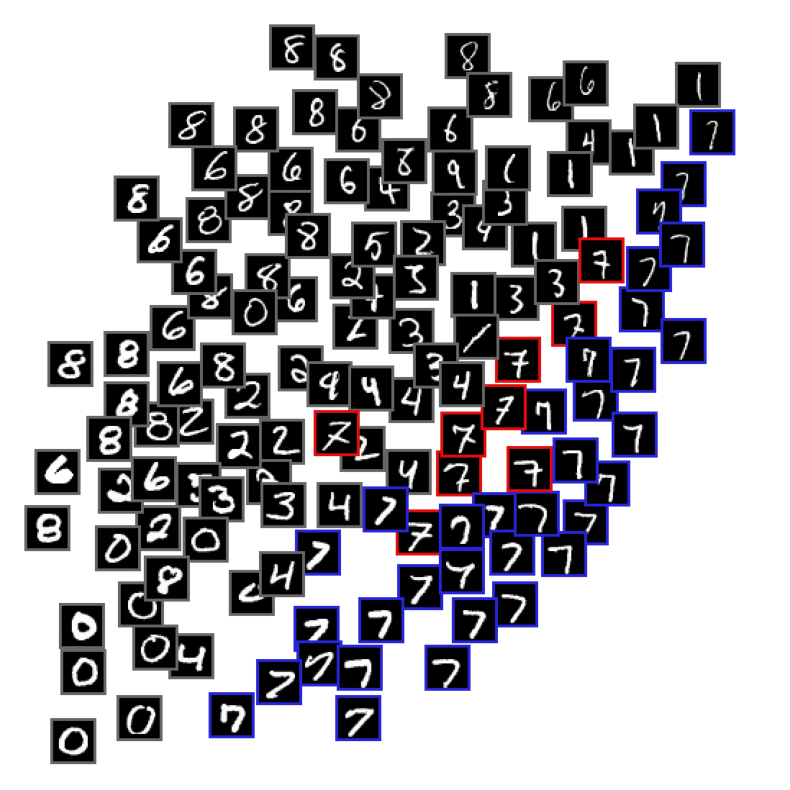

898
130
GM balanced accuracy score with hand-crafted labels :  0.8525190944275096
Epoch: 2 	Training Loss: 221.205322
         	Testing Acc: 0.924913
         	Training Acc: 0.899953


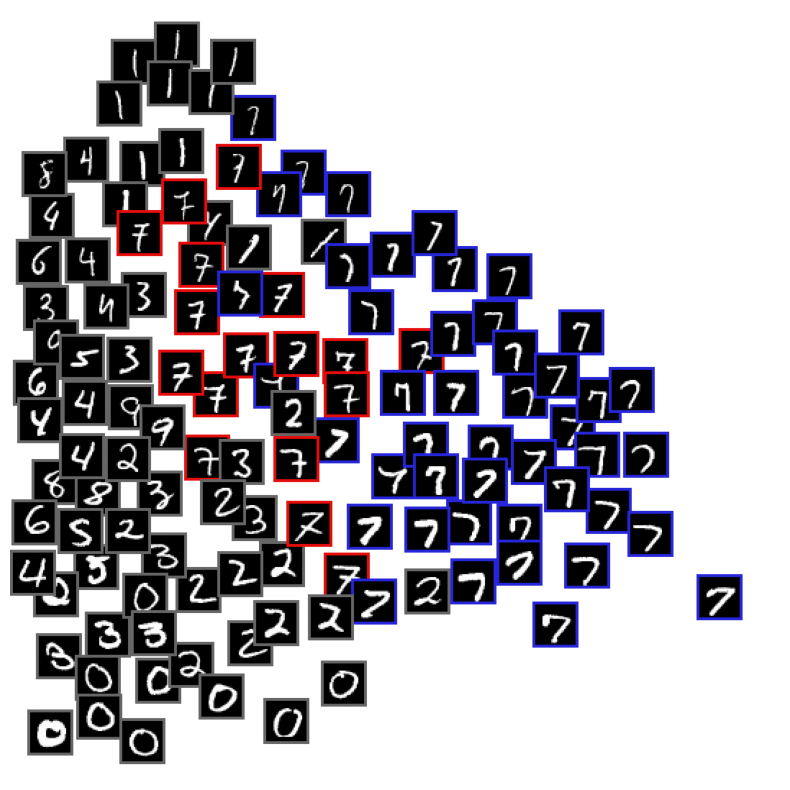

716
312
GM balanced accuracy score with hand-crafted labels :  0.8880193170531219
Epoch: 3 	Training Loss: 214.934159
         	Testing Acc: 0.953559
         	Training Acc: 0.934434


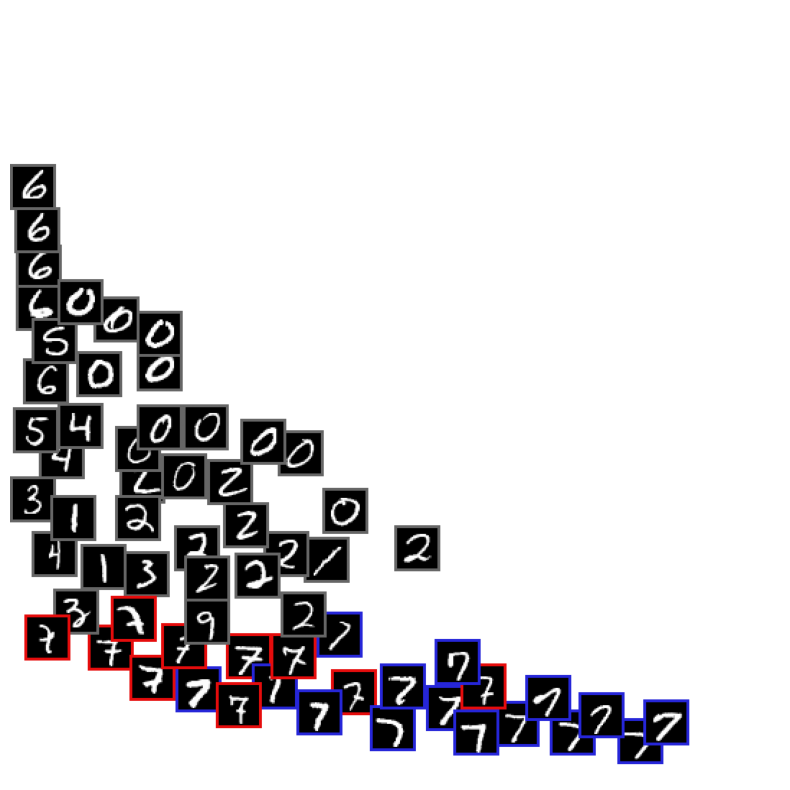

727
301
GM balanced accuracy score with hand-crafted labels :  0.8708942699592424
Epoch: 4 	Training Loss: 198.527207
         	Testing Acc: 0.961372
         	Training Acc: 0.950926


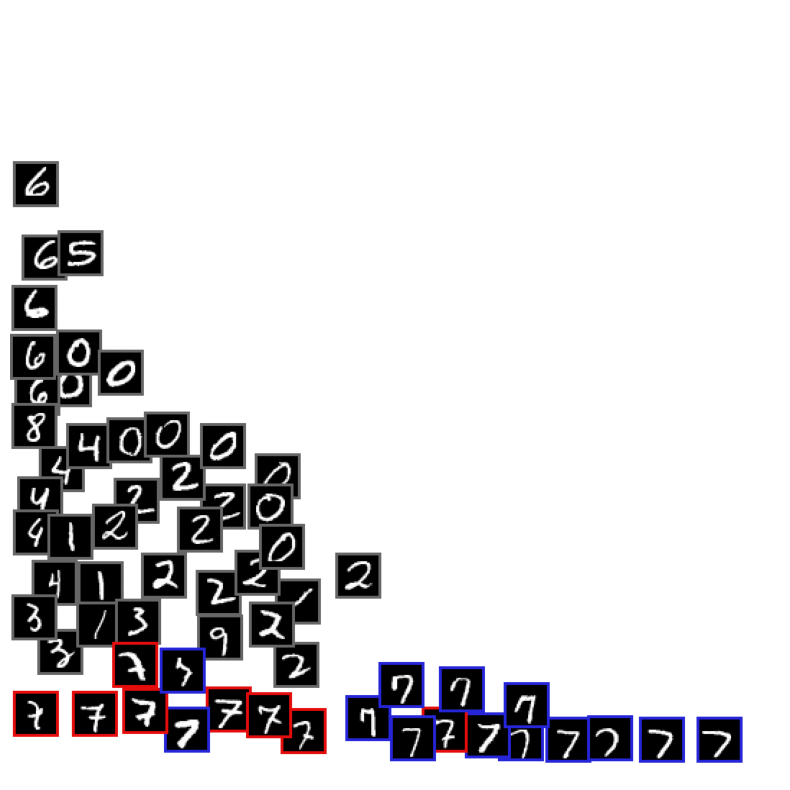

700
328
GM balanced accuracy score with hand-crafted labels :  0.8833784292906806
Epoch: 5 	Training Loss: 191.299499
         	Testing Acc: 0.969184
         	Training Acc: 0.959962


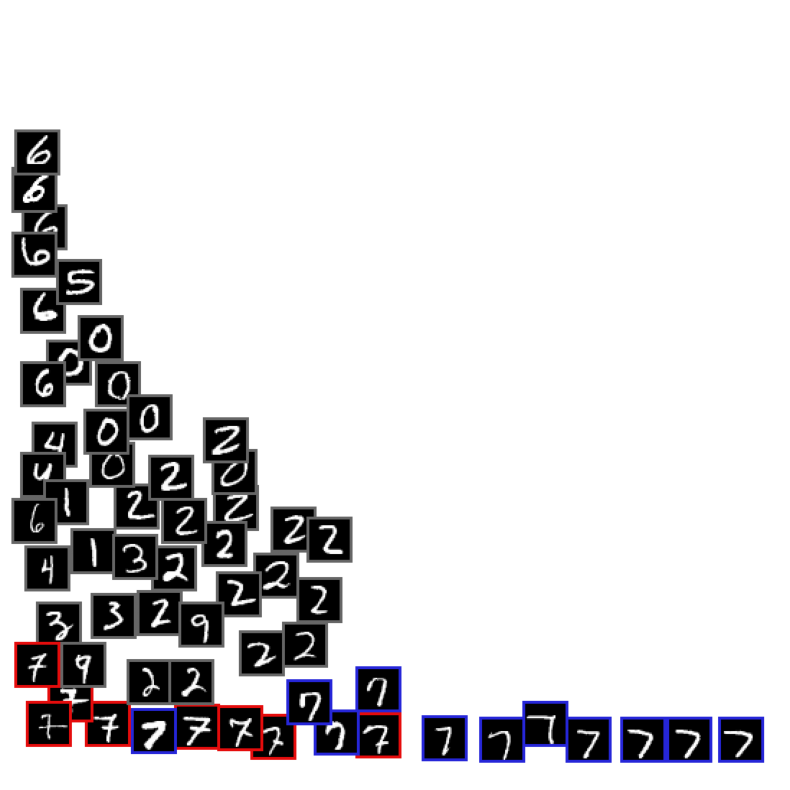

710
318
GM balanced accuracy score with hand-crafted labels :  0.886871938897832
Epoch: 6 	Training Loss: 182.819073
         	Testing Acc: 0.969184
         	Training Acc: 0.968873


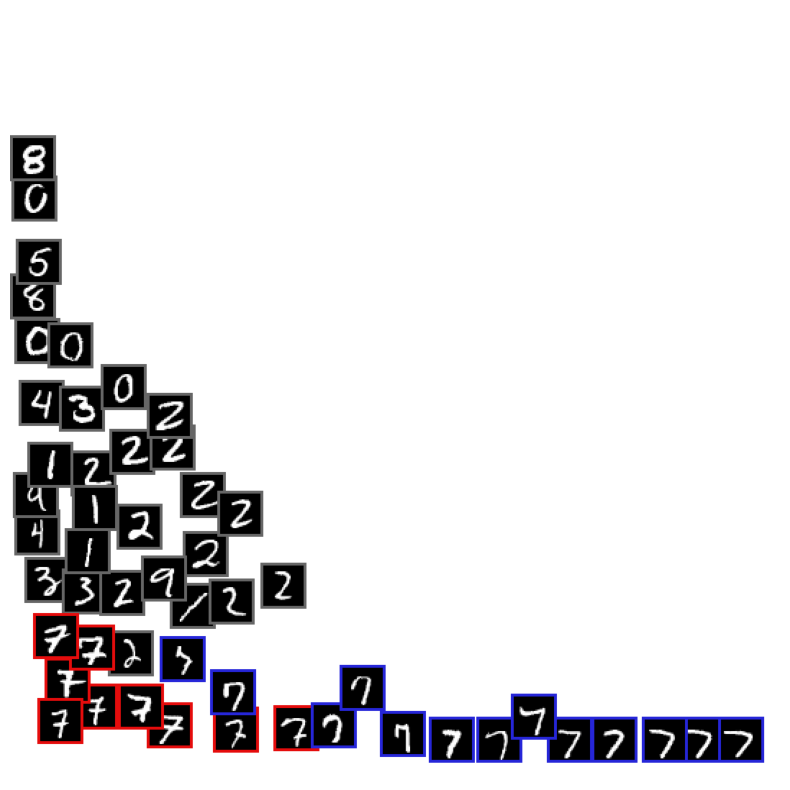

718
310
GM balanced accuracy score with hand-crafted labels :  0.8986710963455149
Epoch: 7 	Training Loss: 172.446656
         	Testing Acc: 0.978299
         	Training Acc: 0.972150


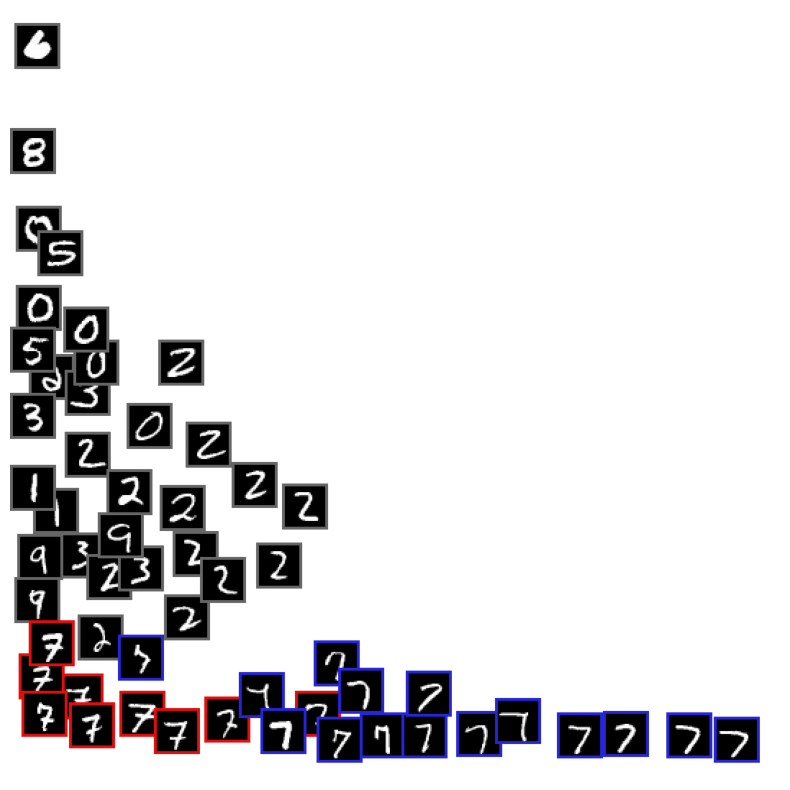

651
377
GM balanced accuracy score with hand-crafted labels :  0.8588039867109635
Epoch: 8 	Training Loss: 173.633946
         	Testing Acc: 0.980903
         	Training Acc: 0.974134


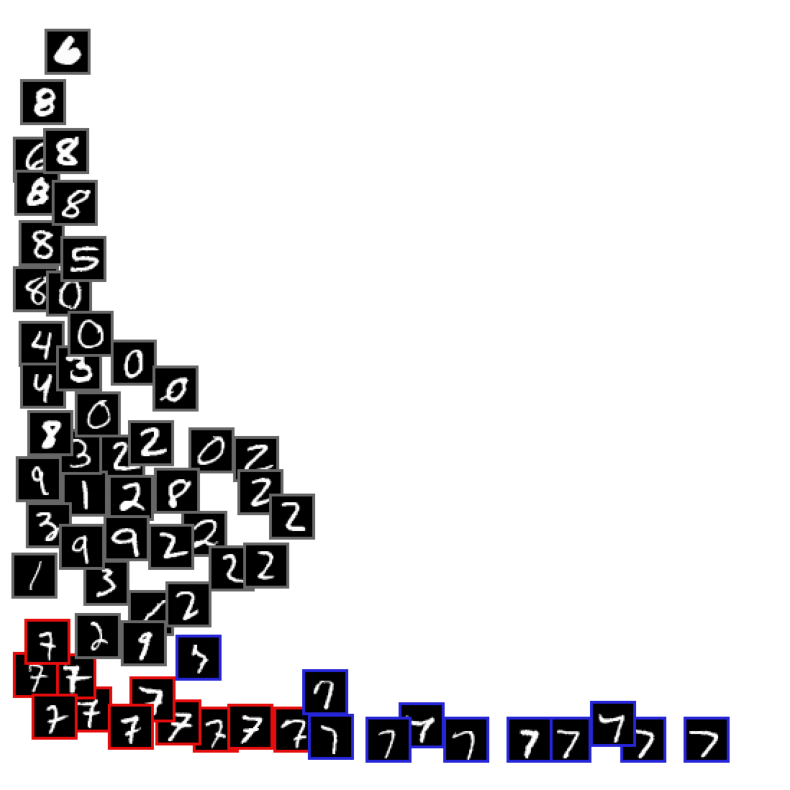

765
263
GM balanced accuracy score with hand-crafted labels :  0.8998184745008049
Epoch: 9 	Training Loss: 157.300352
         	Testing Acc: 0.967448
         	Training Acc: 0.978050


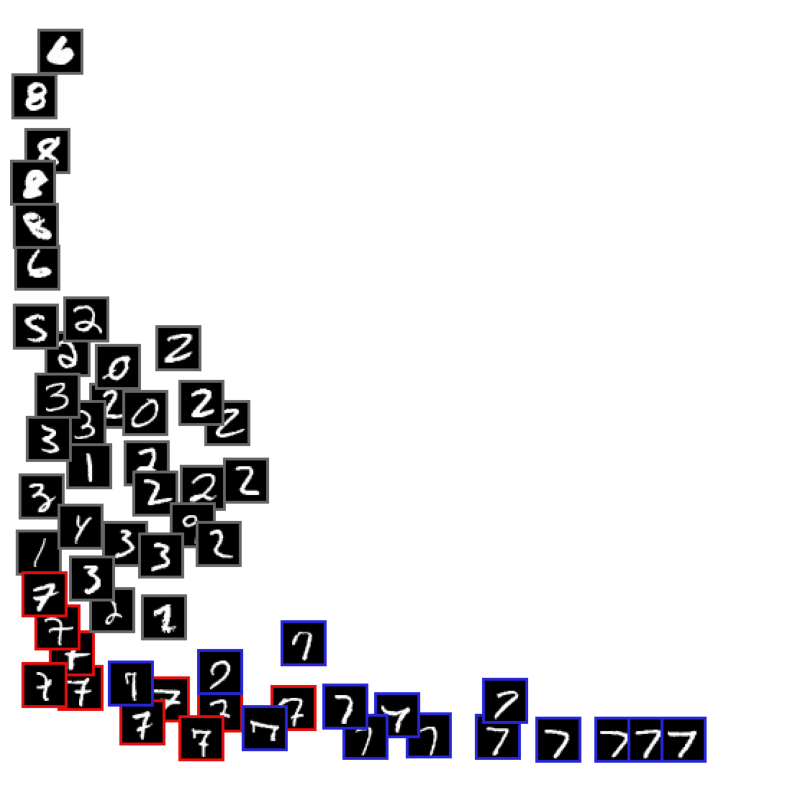

758
270
GM balanced accuracy score with hand-crafted labels :  0.9136212624584718
Epoch: 10 	Training Loss: 153.589165
         	Testing Acc: 0.984809
         	Training Acc: 0.977248


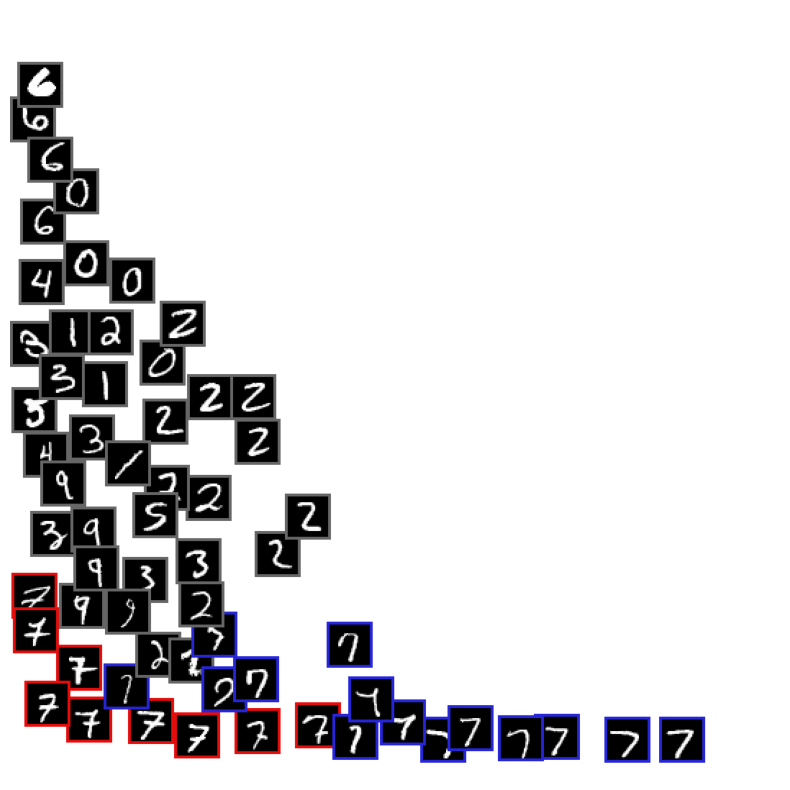

747
281
GM balanced accuracy score with hand-crafted labels :  0.9102990033222591
Epoch: 11 	Training Loss: 150.313890
         	Testing Acc: 0.983941
         	Training Acc: 0.979095


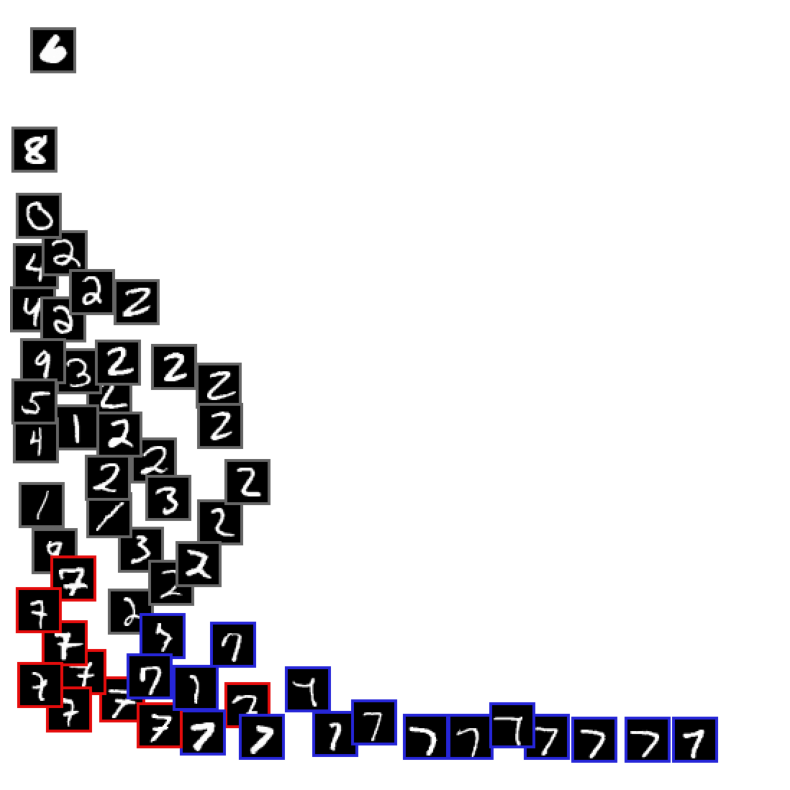

729
299
GM balanced accuracy score with hand-crafted labels :  0.886871938897832
Epoch: 12 	Training Loss: 150.920954
         	Testing Acc: 0.960503
         	Training Acc: 0.980924


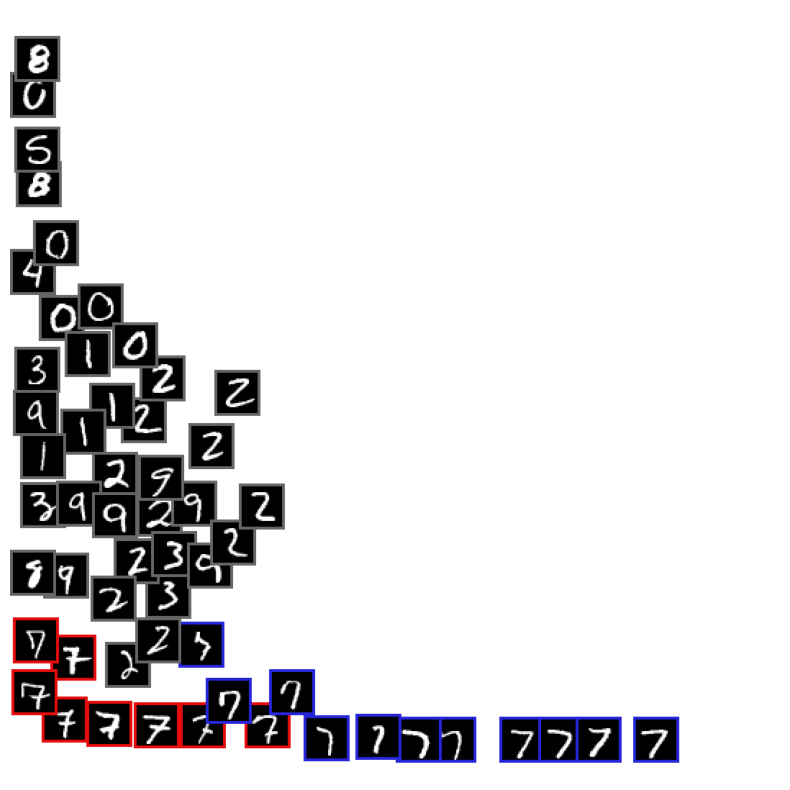

798
230
GM balanced accuracy score with hand-crafted labels :  0.8893379456793506
Epoch: 13 	Training Loss: 142.218730
         	Testing Acc: 0.981337
         	Training Acc: 0.983329


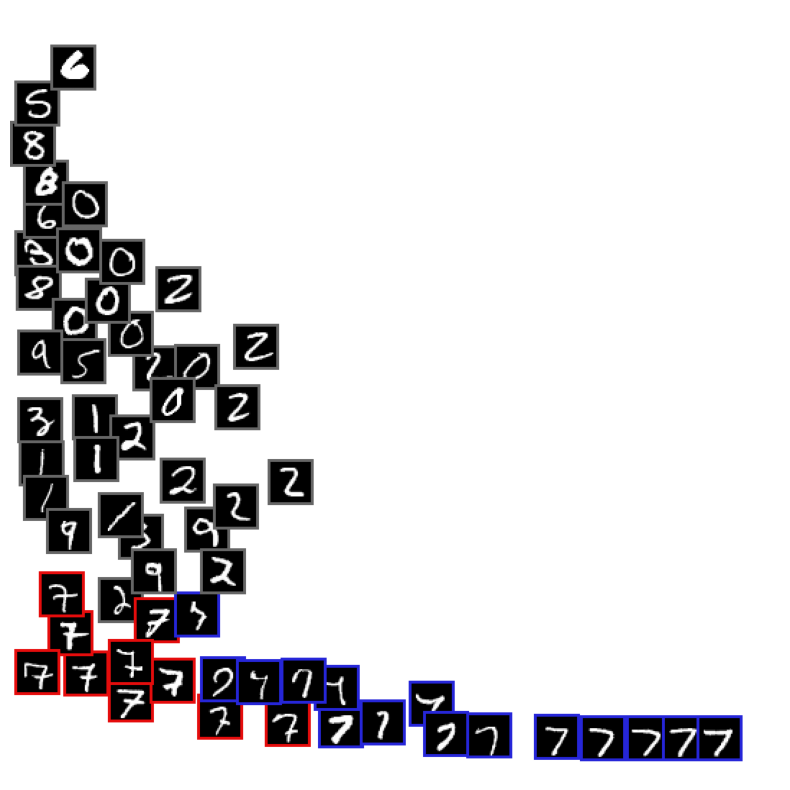

773
255
GM balanced accuracy score with hand-crafted labels :  0.9235880398671097
Epoch: 14 	Training Loss: 140.203171
         	Testing Acc: 0.983073
         	Training Acc: 0.982049


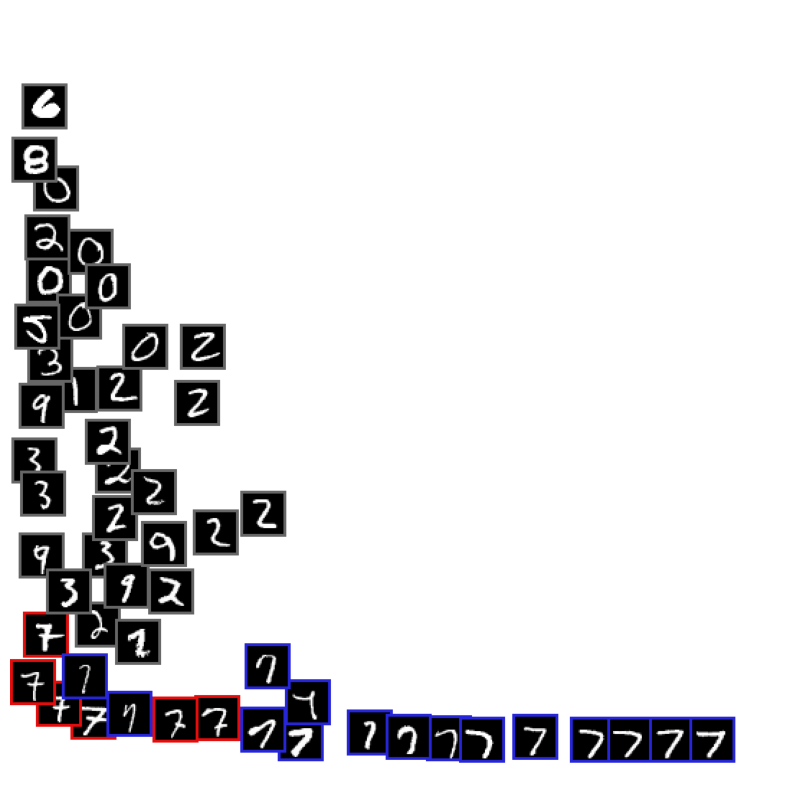

770
258
GM balanced accuracy score with hand-crafted labels :  0.9202657807308969
Epoch: 15 	Training Loss: 140.345449
         	Testing Acc: 0.987847
         	Training Acc: 0.982678


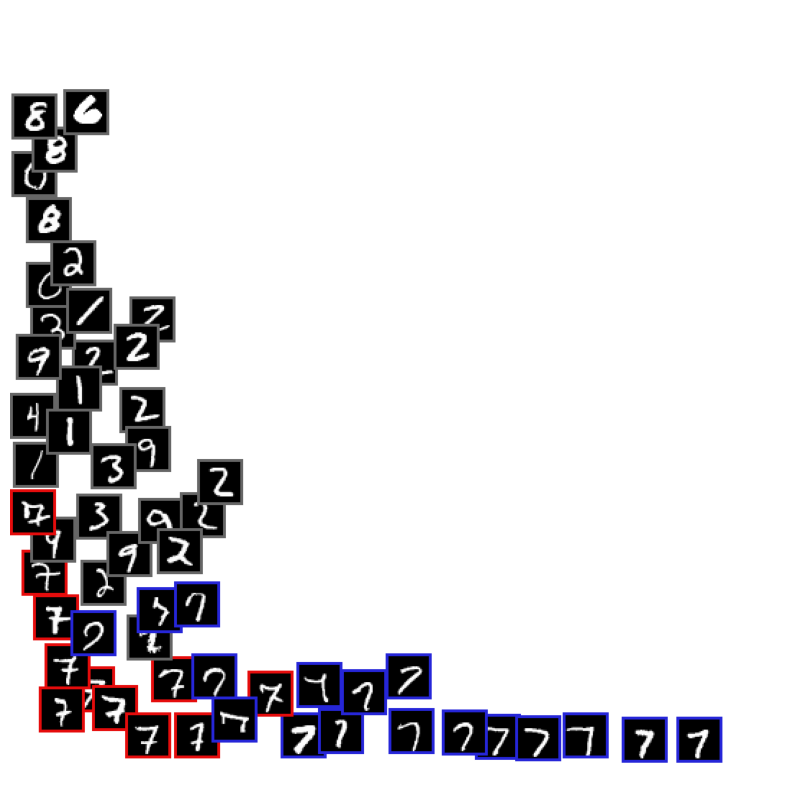

732
296
GM balanced accuracy score with hand-crafted labels :  0.8867006884268931
Epoch: 16 	Training Loss: 143.408044
         	Testing Acc: 0.988715
         	Training Acc: 0.984427


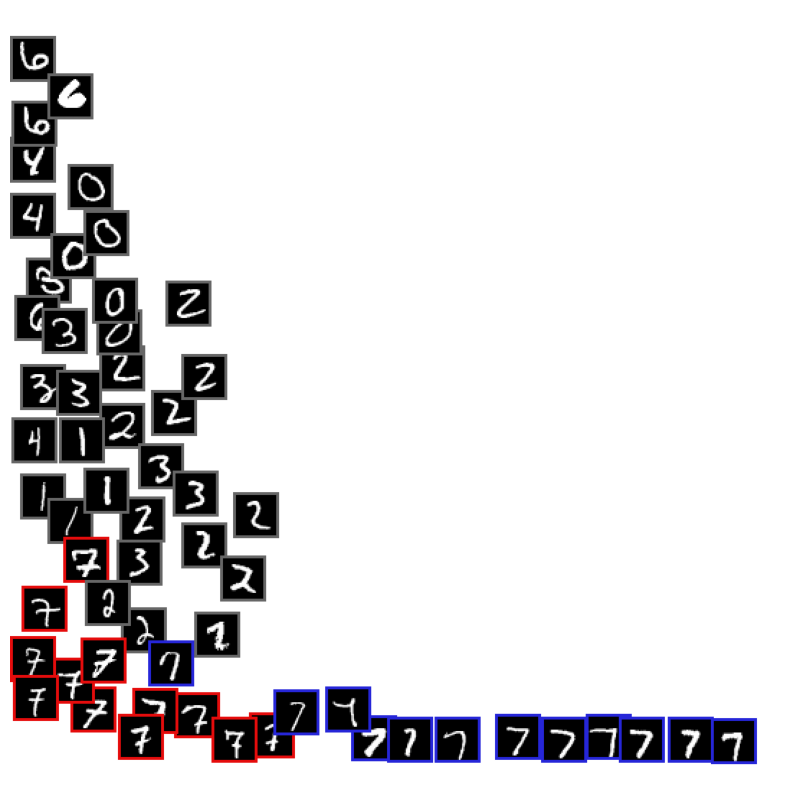

783
245
GM balanced accuracy score with hand-crafted labels :  0.8994759735589273
Epoch: 17 	Training Loss: 136.260509
         	Testing Acc: 0.953559
         	Training Acc: 0.986345


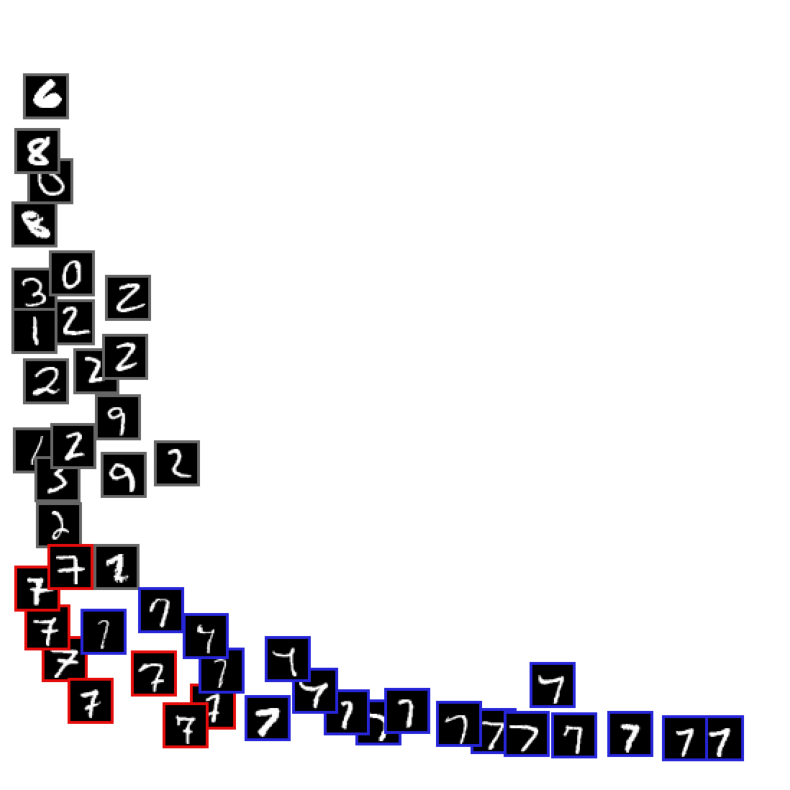

711
317
GM balanced accuracy score with hand-crafted labels :  0.893687707641196
Epoch: 18 	Training Loss: 140.019153
         	Testing Acc: 0.989149
         	Training Acc: 0.985778


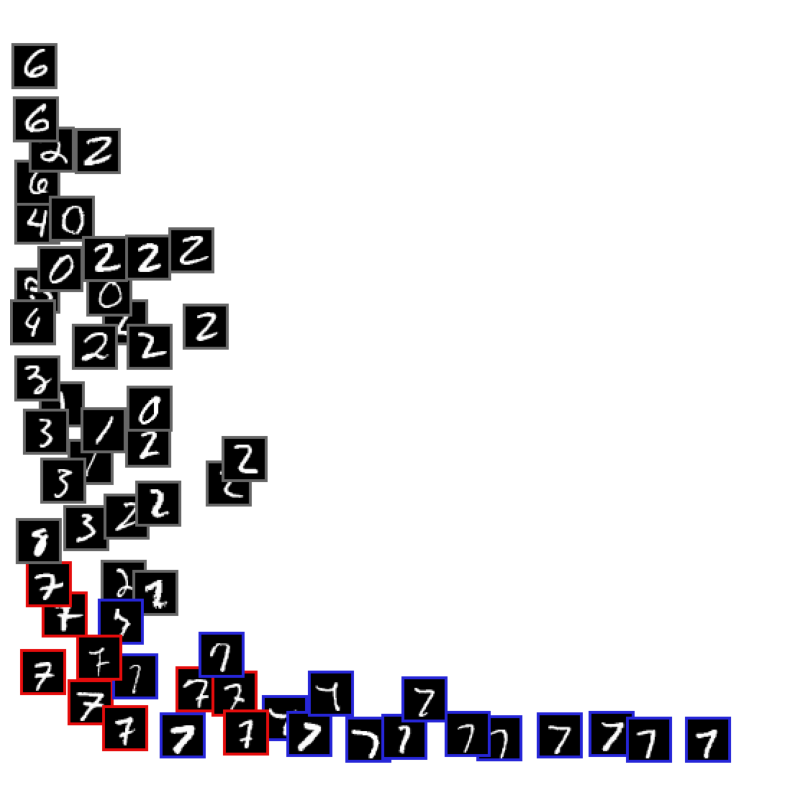

743
285
GM balanced accuracy score with hand-crafted labels :  0.8916840771312121
Epoch: 19 	Training Loss: 137.628913
         	Testing Acc: 0.985677
         	Training Acc: 0.984839


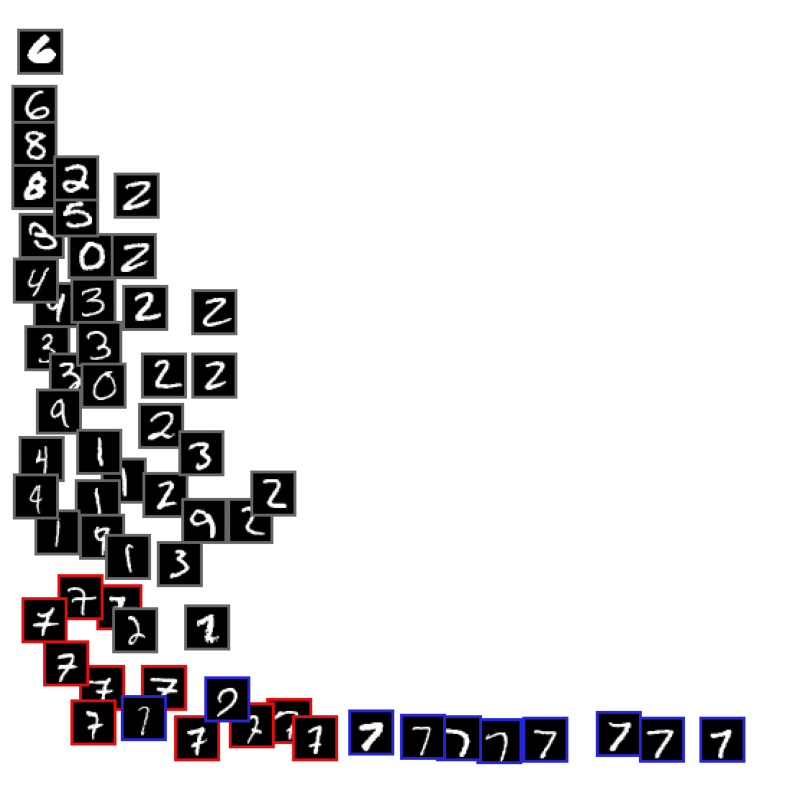

818
210
GM balanced accuracy score with hand-crafted labels :  0.9004521012432785
Epoch: 20 	Training Loss: 129.684193
         	Testing Acc: 0.987847
         	Training Acc: 0.985562


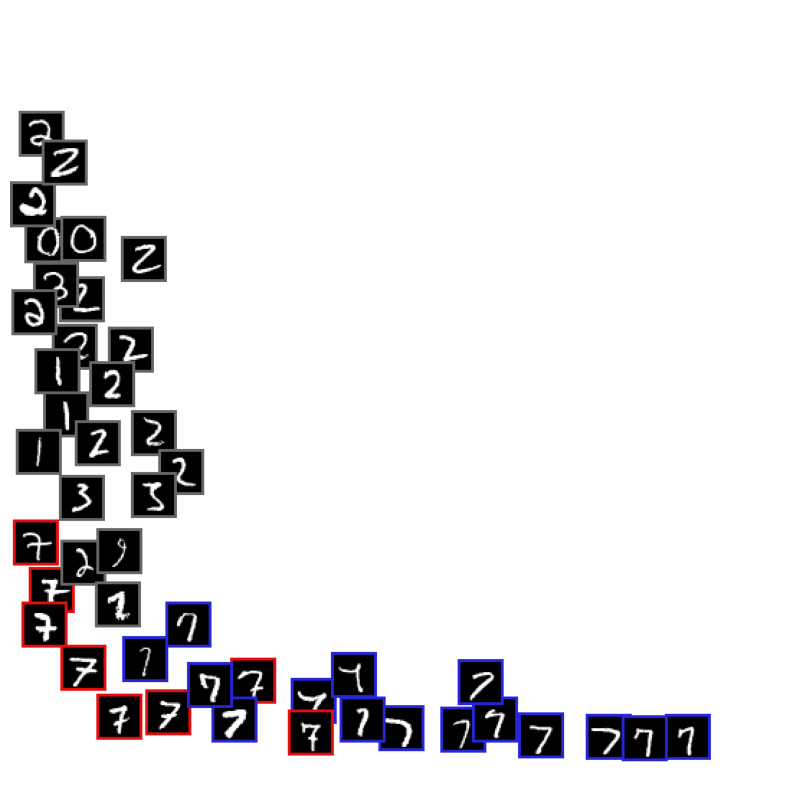

730
298
GM balanced accuracy score with hand-crafted labels :  0.8968387163064699
Epoch: 21 	Training Loss: 137.385321
         	Testing Acc: 0.992622
         	Training Acc: 0.986682


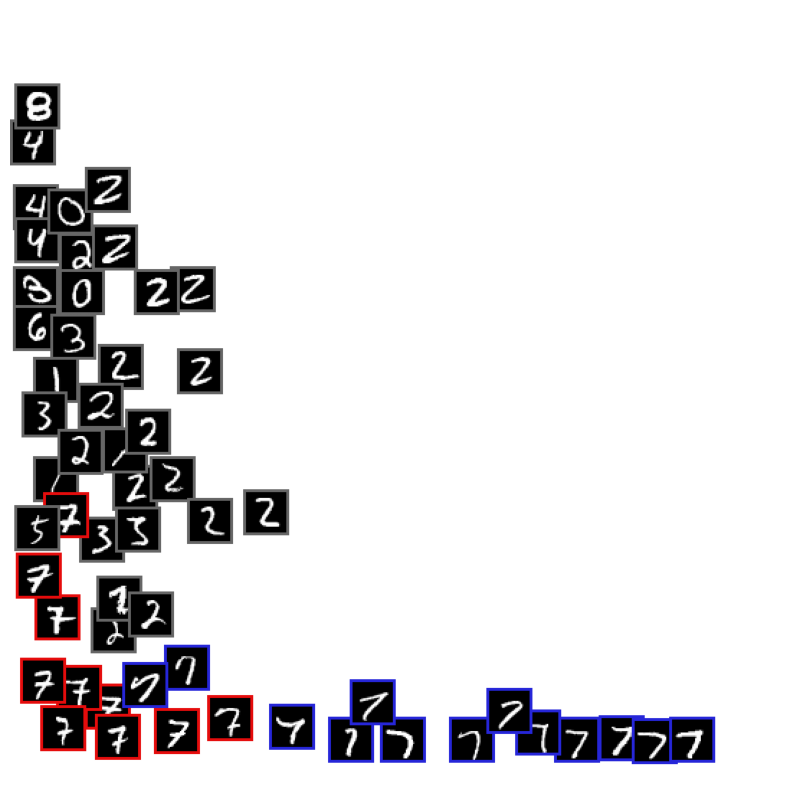

788
240
GM balanced accuracy score with hand-crafted labels :  0.8755351577216837
Epoch: 22 	Training Loss: 130.559378
         	Testing Acc: 0.991319
         	Training Acc: 0.988914


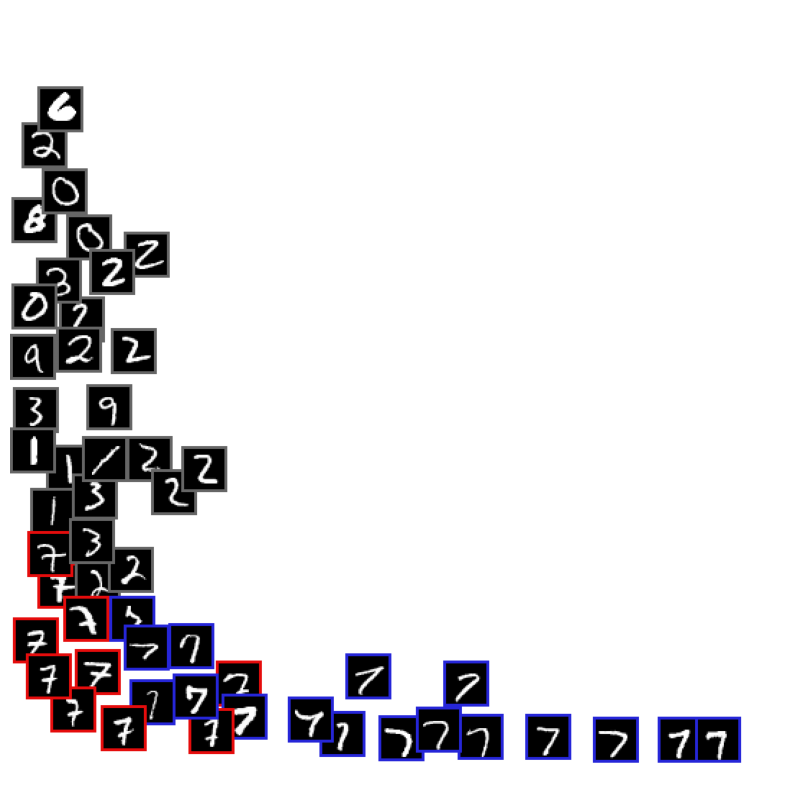

747
281
GM balanced accuracy score with hand-crafted labels :  0.8915128266602733
Epoch: 23 	Training Loss: 131.822692
         	Testing Acc: 0.969184
         	Training Acc: 0.986664


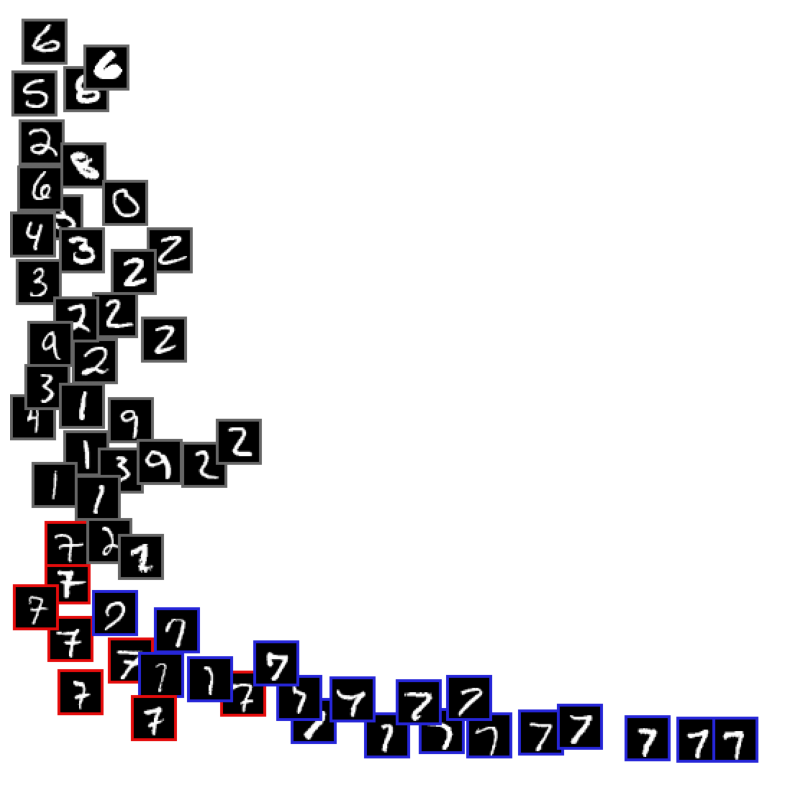

738
290
GM balanced accuracy score with hand-crafted labels :  0.896667465835531
Epoch: 24 	Training Loss: 130.277177
         	Testing Acc: 0.983941
         	Training Acc: 0.987869


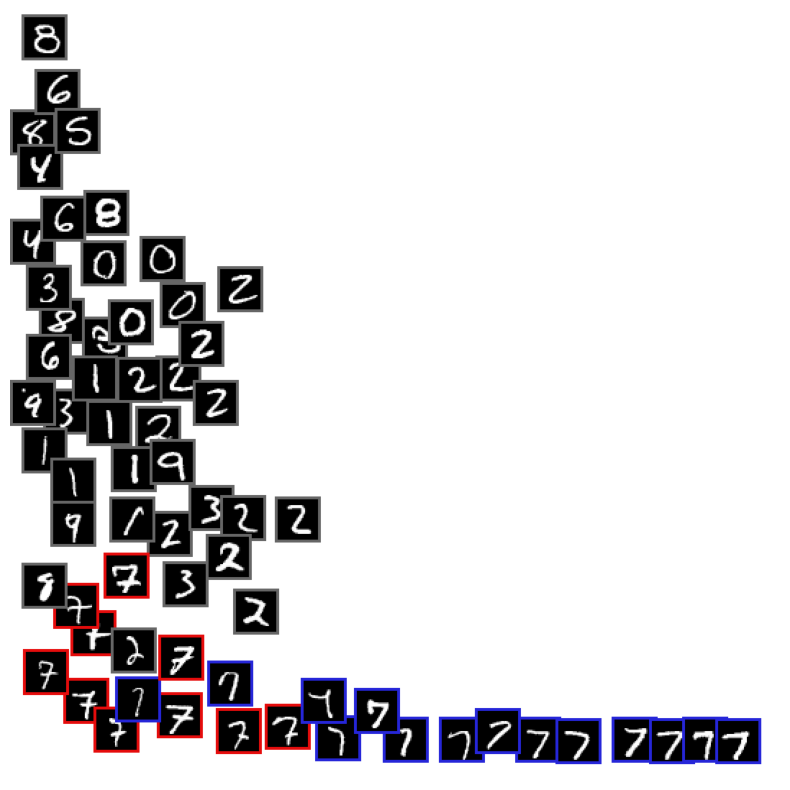

815
213
GM balanced accuracy score with hand-crafted labels :  0.8768537863479124
Epoch: 25 	Training Loss: 130.590862
         	Testing Acc: 0.970052
         	Training Acc: 0.986992


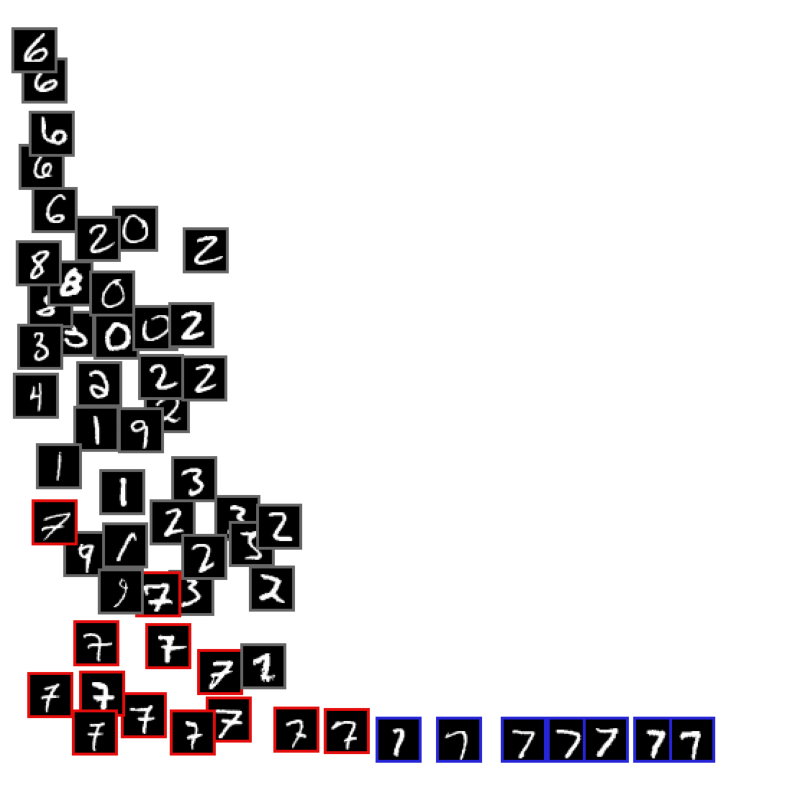

789
239
GM balanced accuracy score with hand-crafted labels :  0.8788574168578964
Epoch: 26 	Training Loss: 130.499020
         	Testing Acc: 0.986111
         	Training Acc: 0.987400


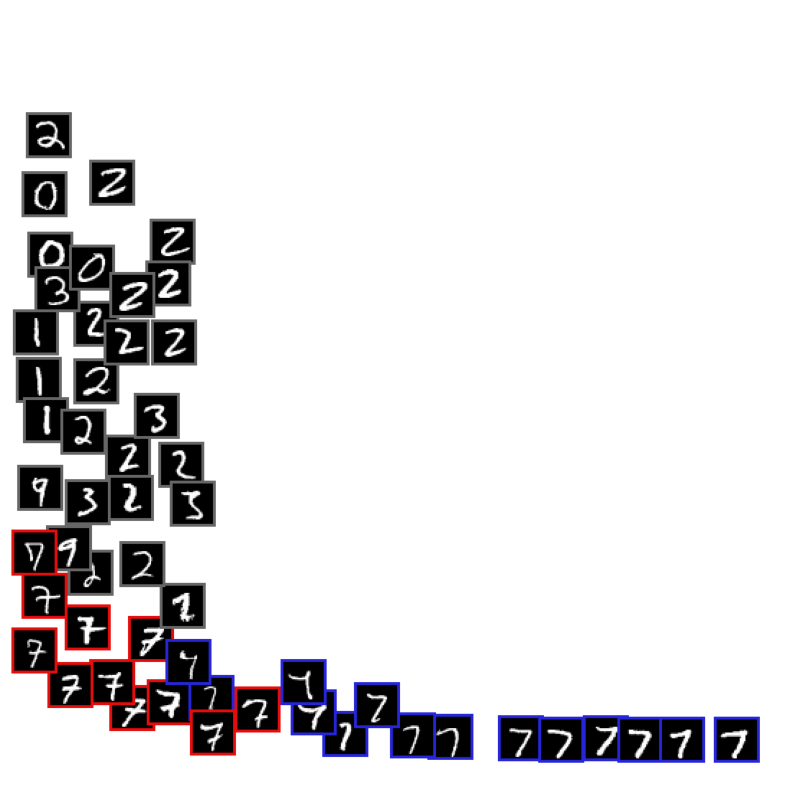

779
249
GM balanced accuracy score with hand-crafted labels :  0.8723841490564099
Epoch: 27 	Training Loss: 131.023931
         	Testing Acc: 0.994358
         	Training Acc: 0.987719


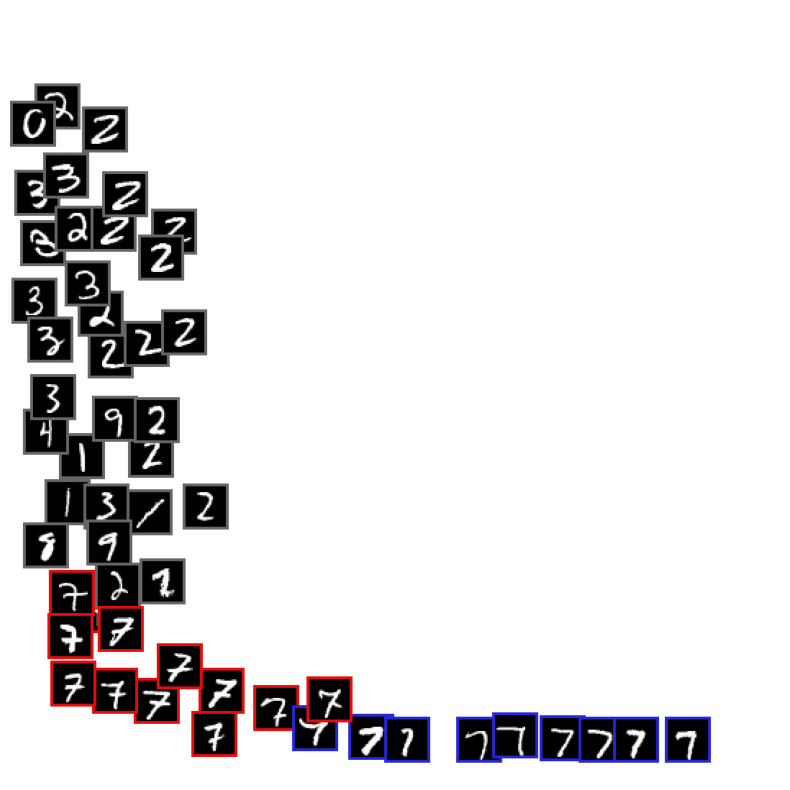

809
219
GM balanced accuracy score with hand-crafted labels :  0.8731890262698223
Epoch: 28 	Training Loss: 128.803768
         	Testing Acc: 0.987847
         	Training Acc: 0.988511


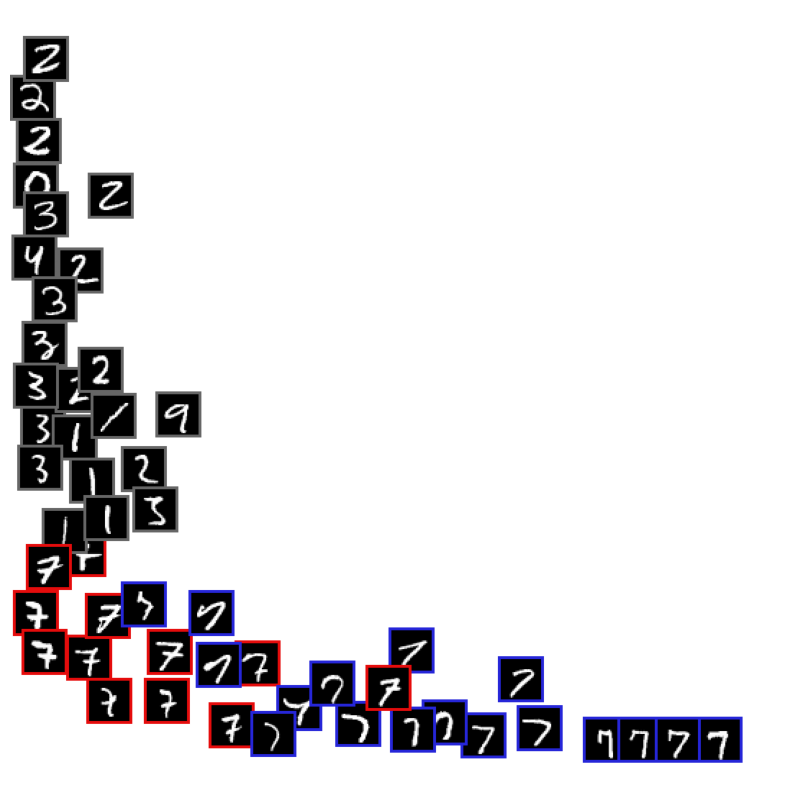

743
285
GM balanced accuracy score with hand-crafted labels :  0.9049731136760626
Epoch: 29 	Training Loss: 132.403055
         	Testing Acc: 0.989149
         	Training Acc: 0.988263


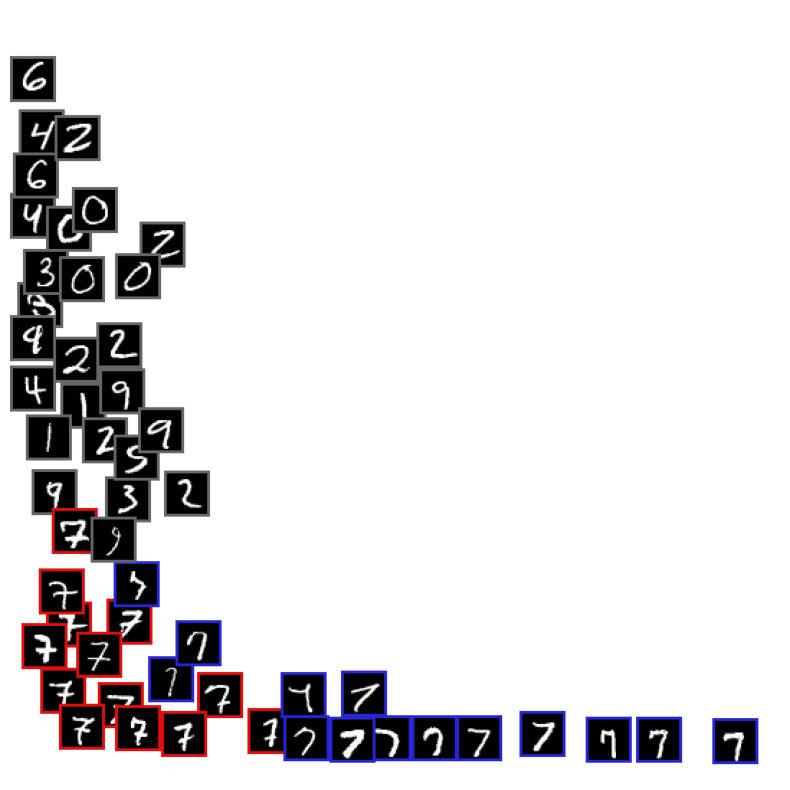

764
264
GM balanced accuracy score with hand-crafted labels :  0.8843545569750317
Epoch: 30 	Training Loss: 128.692037
         	Testing Acc: 0.988281
         	Training Acc: 0.988591


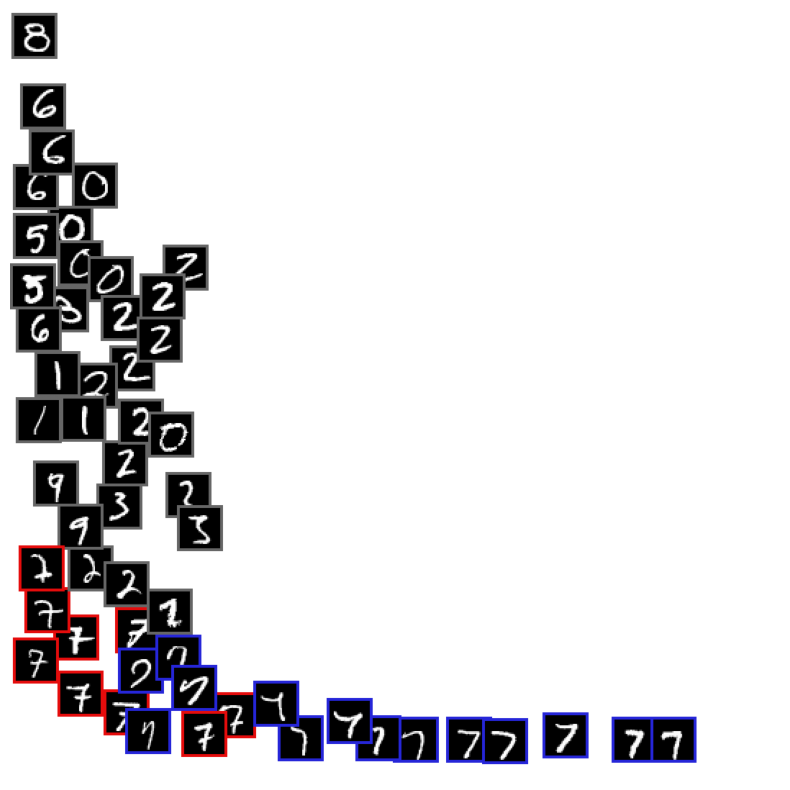

776
252
GM balanced accuracy score with hand-crafted labels :  0.8963249648936535
Epoch: 31 	Training Loss: 126.755705
         	Testing Acc: 0.988281
         	Training Acc: 0.988094


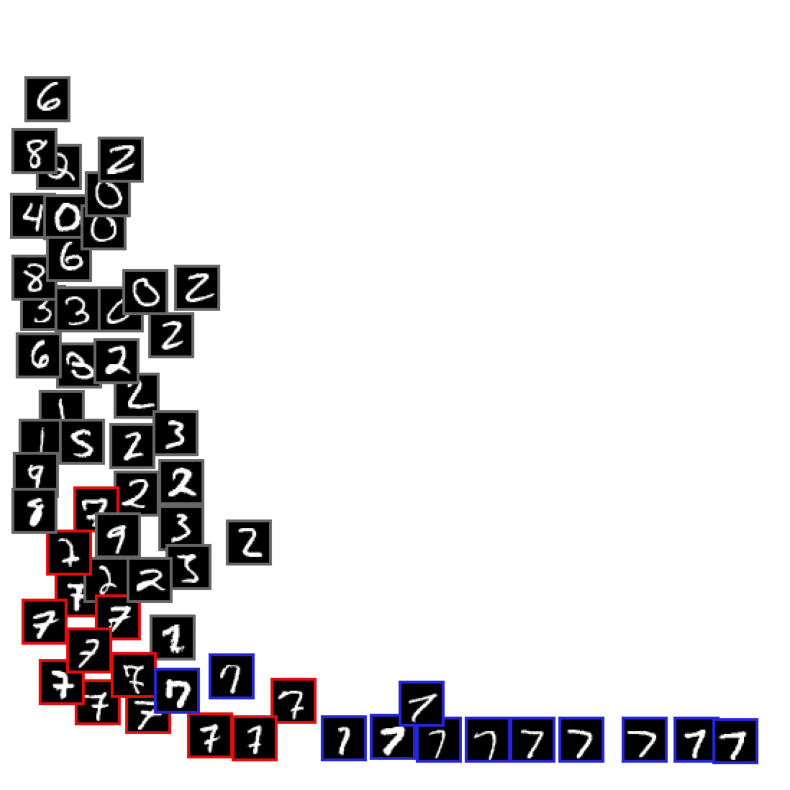

798
230
GM balanced accuracy score with hand-crafted labels :  0.8941500839127308
Epoch: 32 	Training Loss: 125.365188
         	Testing Acc: 0.952257
         	Training Acc: 0.989065


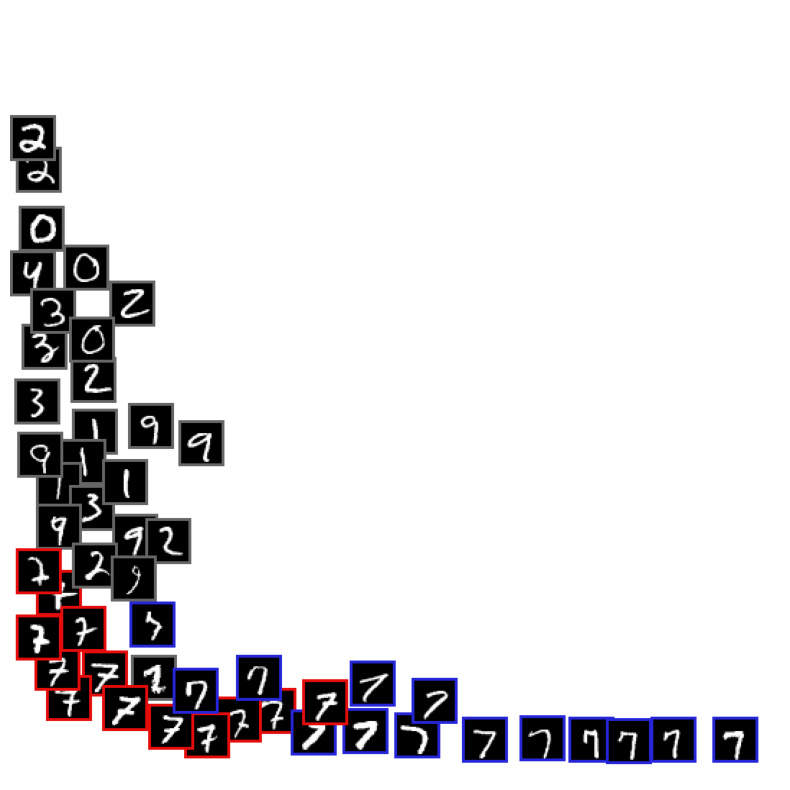

783
245
GM balanced accuracy score with hand-crafted labels :  0.9061204918313526
Epoch: 33 	Training Loss: 126.192996
         	Testing Acc: 0.993056
         	Training Acc: 0.989627


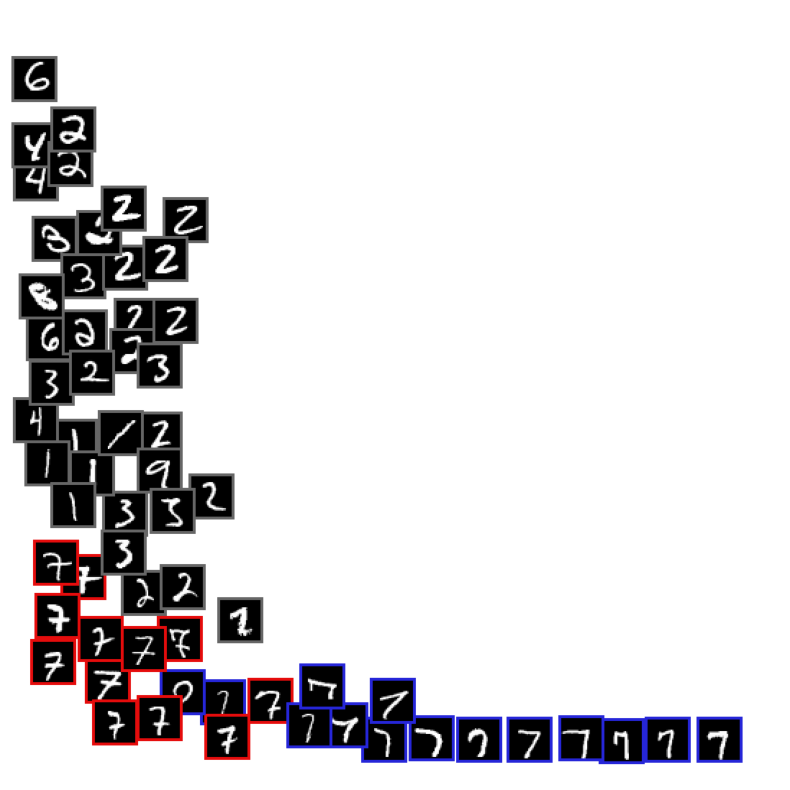

818
210
GM balanced accuracy score with hand-crafted labels :  0.9041168613213686
Epoch: 34 	Training Loss: 121.209874
         	Testing Acc: 0.991319
         	Training Acc: 0.989623


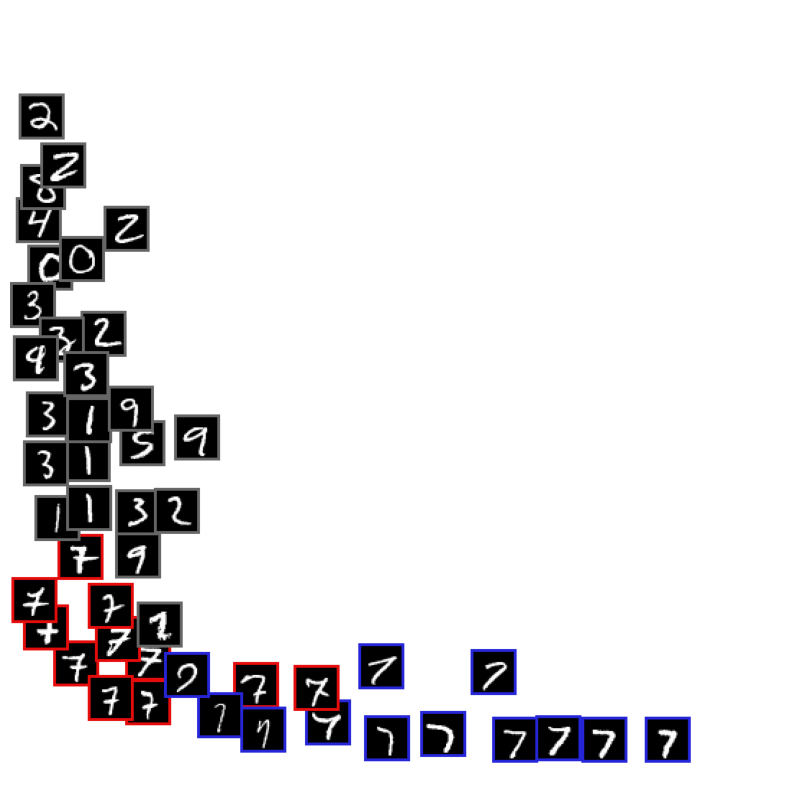

784
244
GM balanced accuracy score with hand-crafted labels :  0.9166010206528068
Epoch: 35 	Training Loss: 123.971163
         	Testing Acc: 0.972656
         	Training Acc: 0.989866


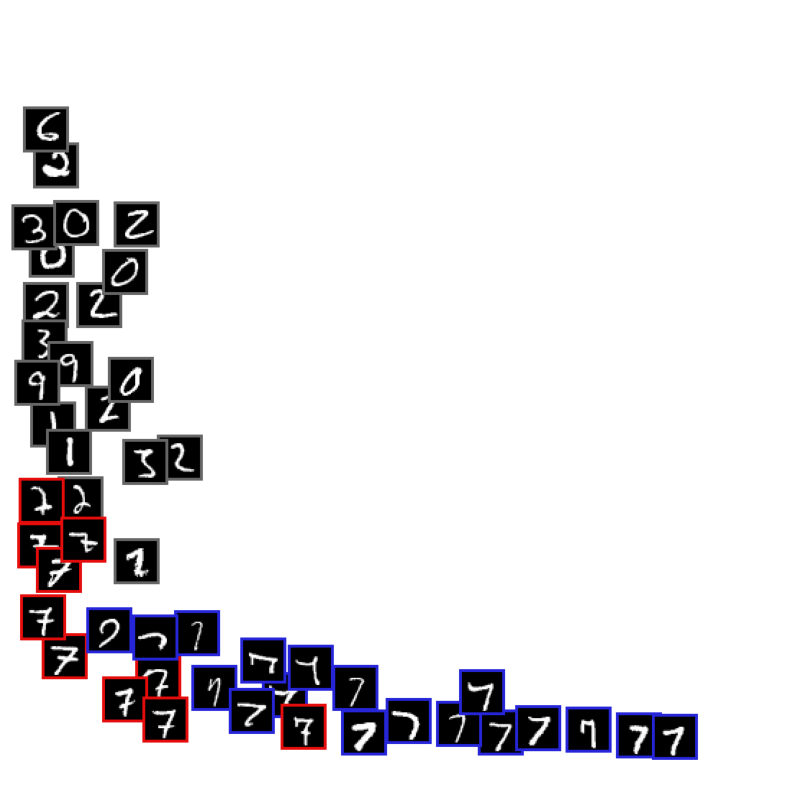

742
286
GM balanced accuracy score with hand-crafted labels :  0.8968387163064699
Epoch: 36 	Training Loss: 127.598627
         	Testing Acc: 0.984809
         	Training Acc: 0.990026


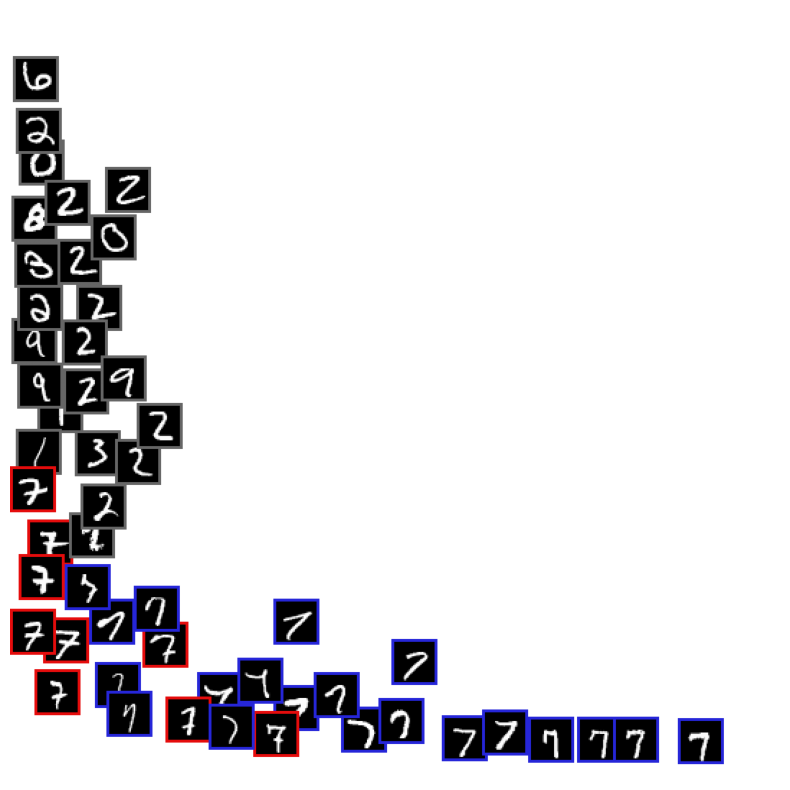

725
303
GM balanced accuracy score with hand-crafted labels :  0.8901941980340446
Epoch: 37 	Training Loss: 127.337290
         	Testing Acc: 0.991319
         	Training Acc: 0.989543


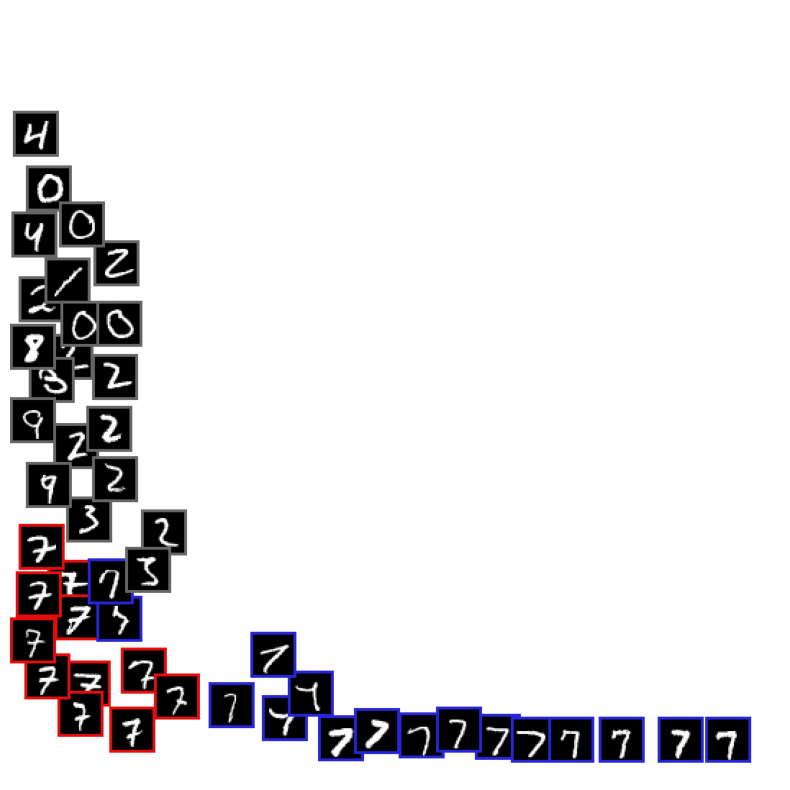

730
298
GM balanced accuracy score with hand-crafted labels :  0.8848683083878481
Epoch: 38 	Training Loss: 128.136753
         	Testing Acc: 0.972222
         	Training Acc: 0.990668


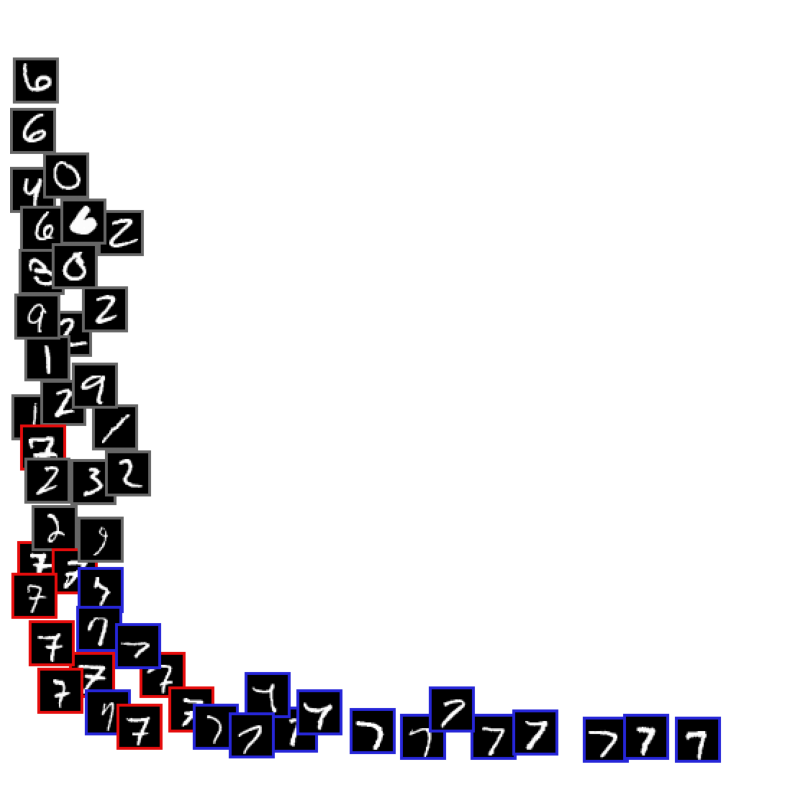

743
285
GM balanced accuracy score with hand-crafted labels :  0.8998184745008049
Epoch: 39 	Training Loss: 124.184300
         	Testing Acc: 0.994358
         	Training Acc: 0.991386


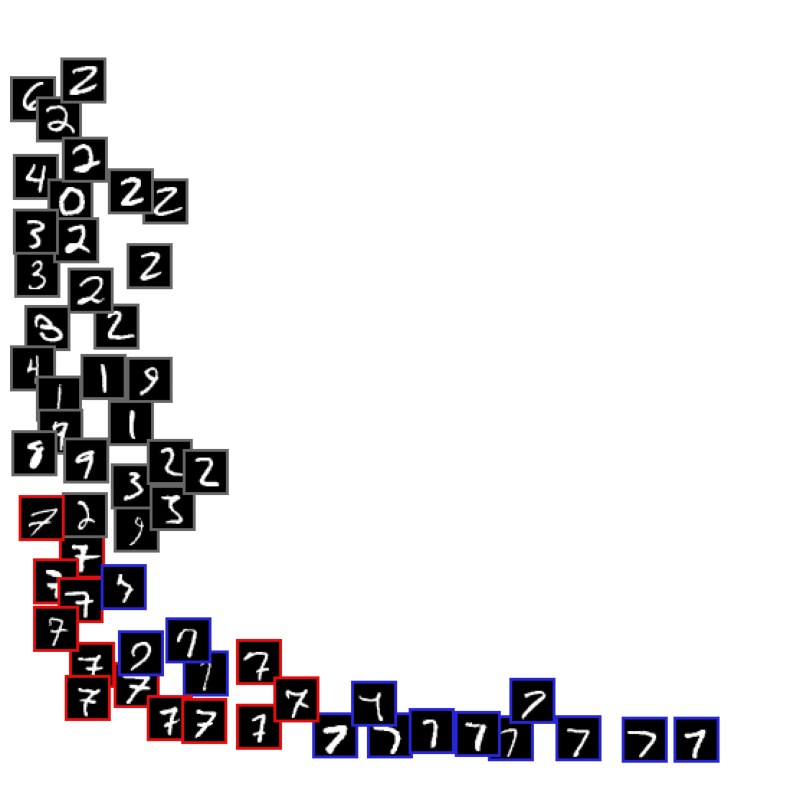

758
270
GM balanced accuracy score with hand-crafted labels :  0.8913415761893345
Epoch: 40 	Training Loss: 123.565745
         	Testing Acc: 0.992622
         	Training Acc: 0.989712


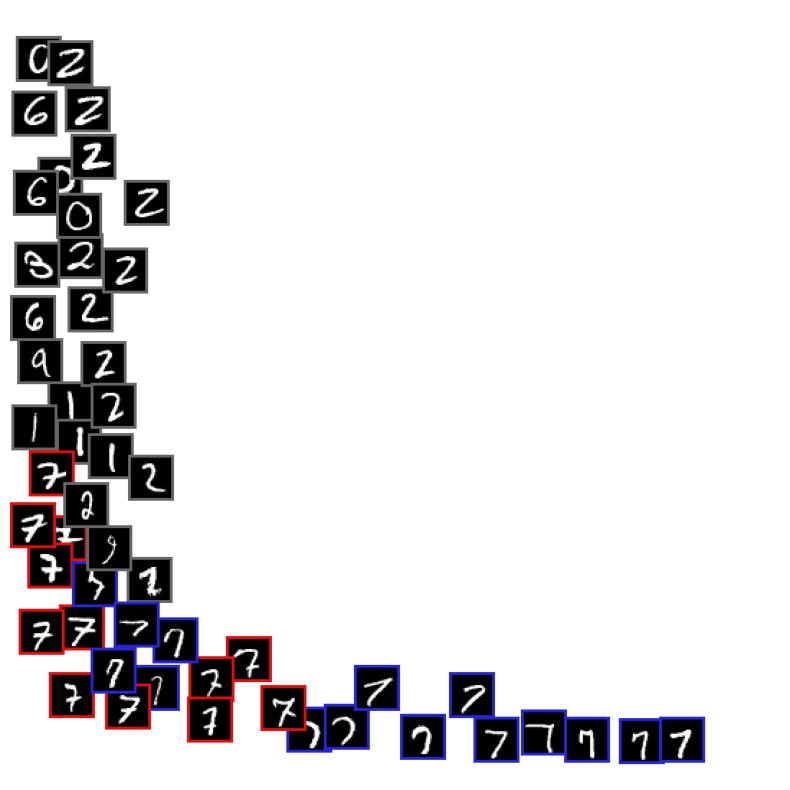

763
265
GM balanced accuracy score with hand-crafted labels :  0.9182621502209131
Epoch: 41 	Training Loss: 122.046593
         	Testing Acc: 0.969184
         	Training Acc: 0.989862


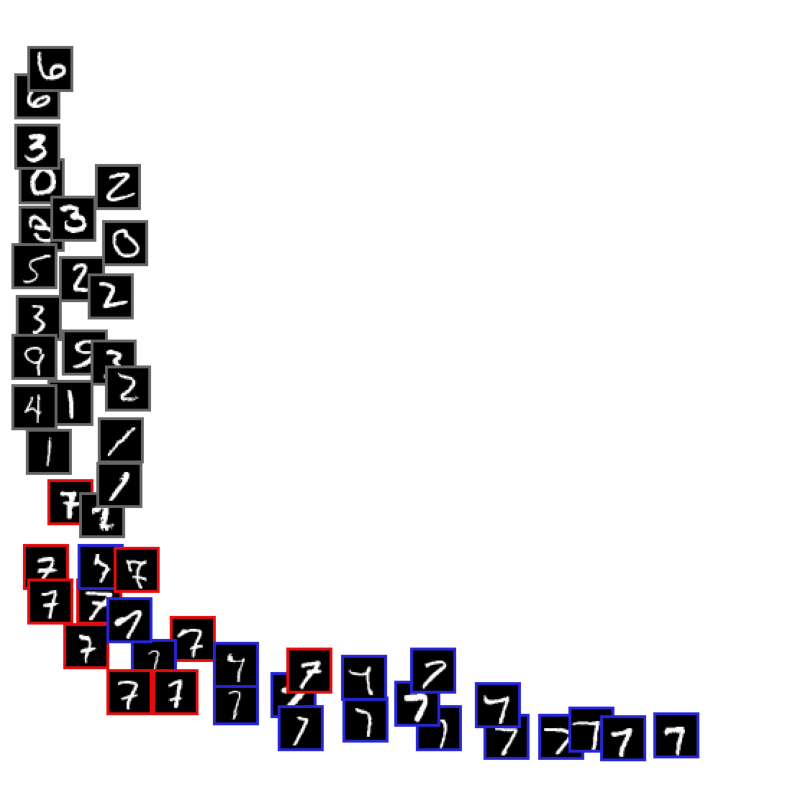

749
279
GM balanced accuracy score with hand-crafted labels :  0.9101277528513203
Epoch: 42 	Training Loss: 122.328064
         	Testing Acc: 0.983507
         	Training Acc: 0.989552


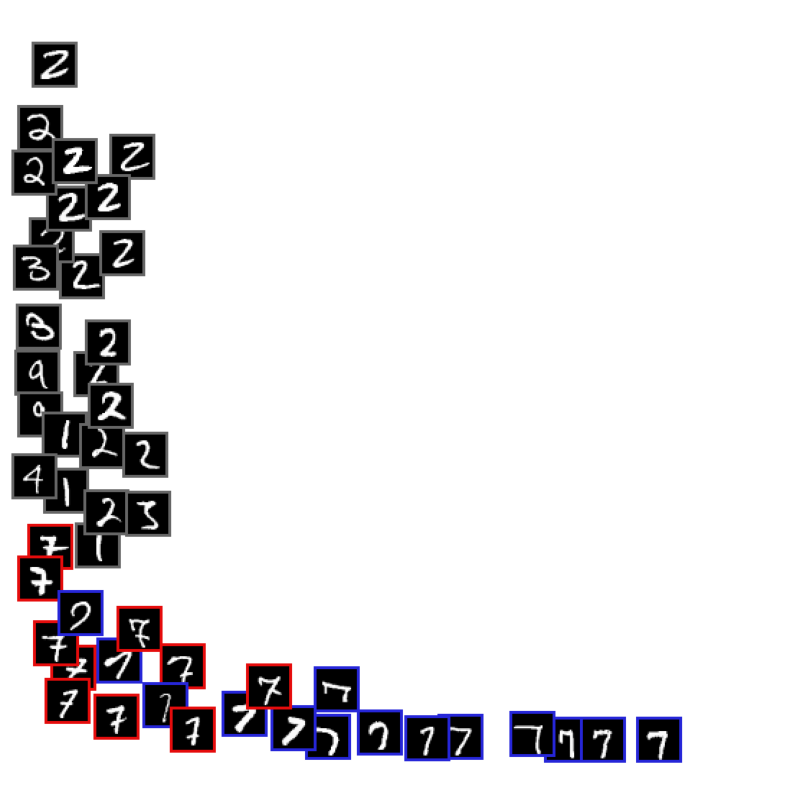

758
270
GM balanced accuracy score with hand-crafted labels :  0.9082953728122752
Epoch: 43 	Training Loss: 124.758512
         	Testing Acc: 0.987413
         	Training Acc: 0.990659


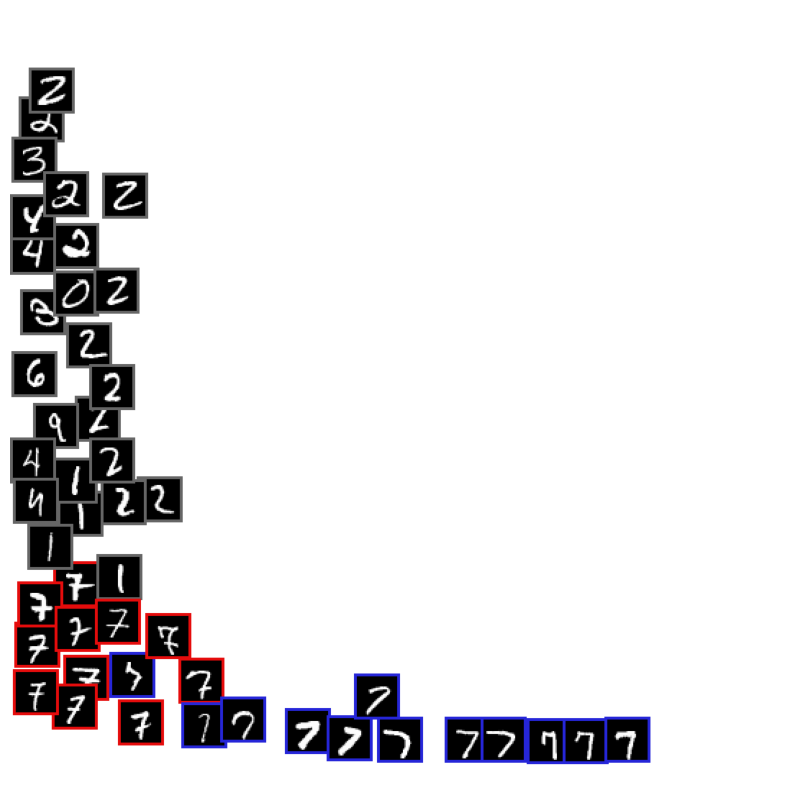

823
205
GM balanced accuracy score with hand-crafted labels :  0.917577148337158
Epoch: 44 	Training Loss: 120.829706
         	Testing Acc: 0.988281
         	Training Acc: 0.990270


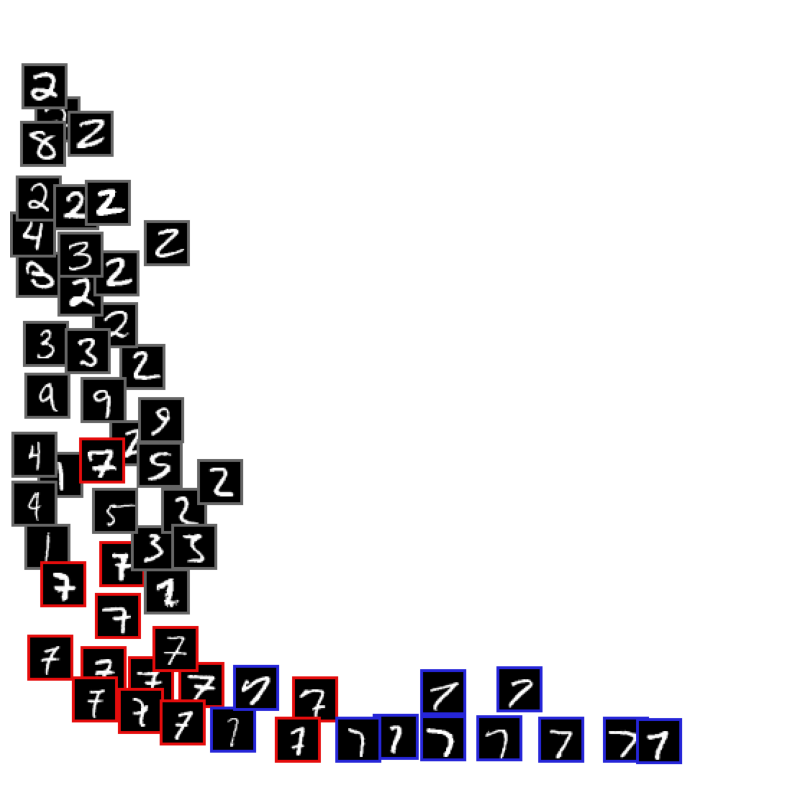

797
231
GM balanced accuracy score with hand-crafted labels :  0.8991334726170497
Epoch: 45 	Training Loss: 120.448447
         	Testing Acc: 0.991753
         	Training Acc: 0.990814


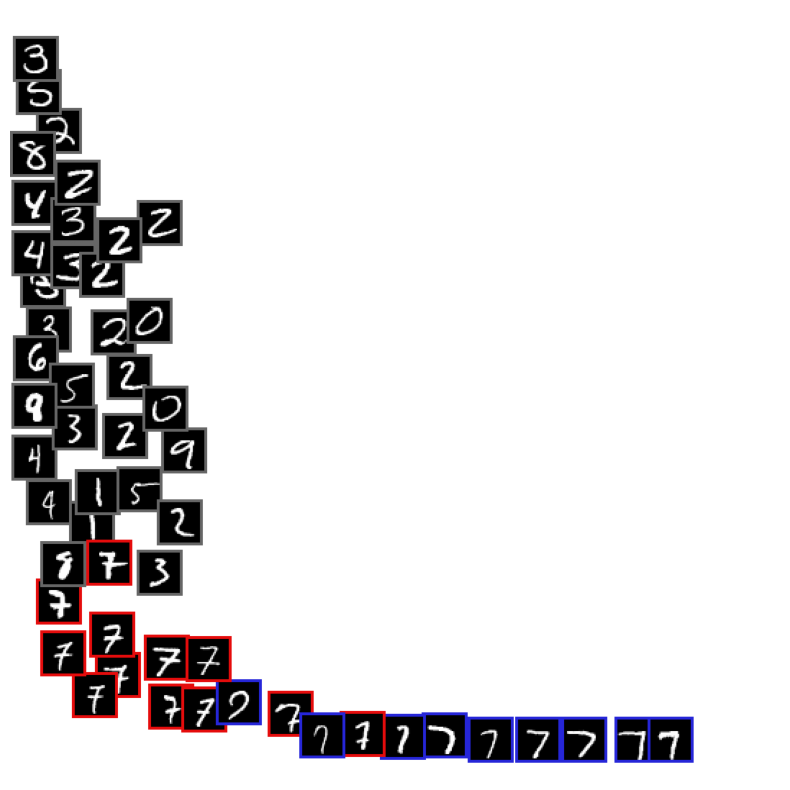

806
222
GM balanced accuracy score with hand-crafted labels :  0.9074391204575813
Epoch: 46 	Training Loss: 117.287304
         	Testing Acc: 0.993924
         	Training Acc: 0.991461


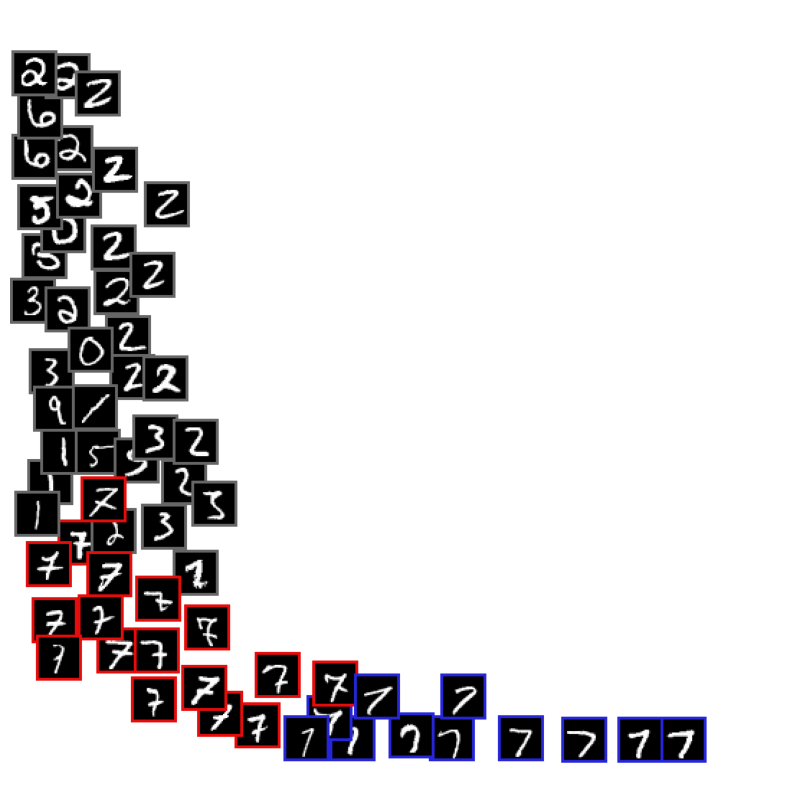

806
222
GM balanced accuracy score with hand-crafted labels :  0.9059492413604138
Epoch: 47 	Training Loss: 118.546353
         	Testing Acc: 0.986111
         	Training Acc: 0.991376


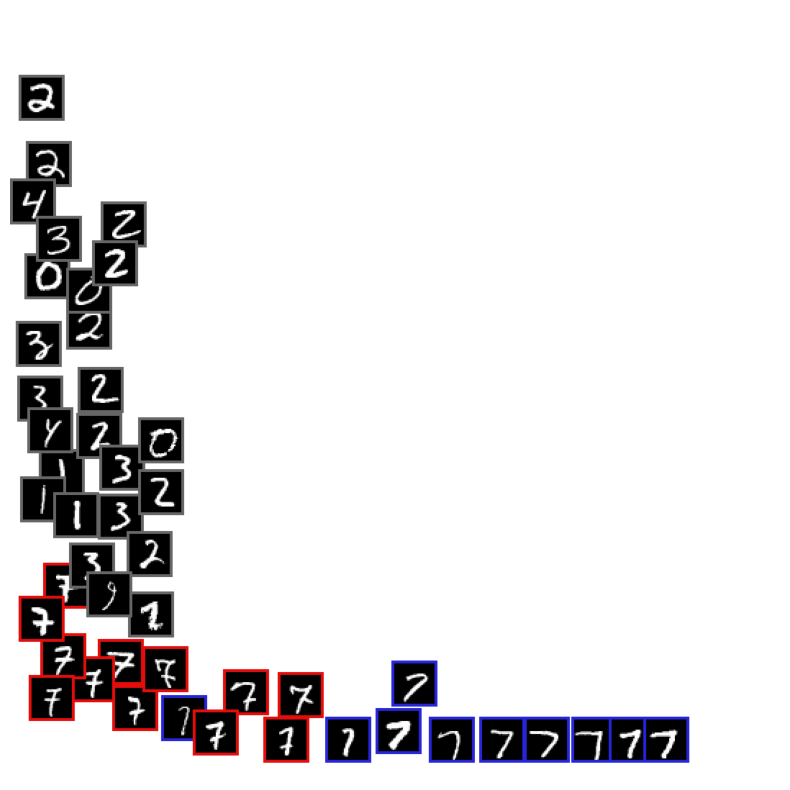

816
212
GM balanced accuracy score with hand-crafted labels :  0.914426139671884
Epoch: 48 	Training Loss: 119.202572
         	Testing Acc: 0.982205
         	Training Acc: 0.990823


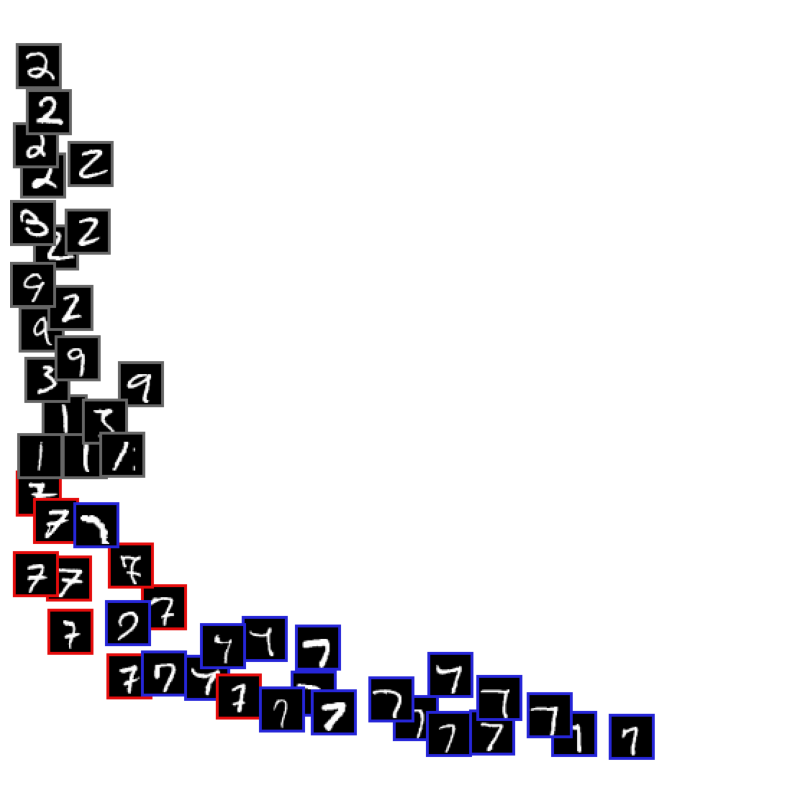

735
293
GM balanced accuracy score with hand-crafted labels :  0.9018221050107889
Epoch: 49 	Training Loss: 124.008416
         	Testing Acc: 0.990885
         	Training Acc: 0.992103


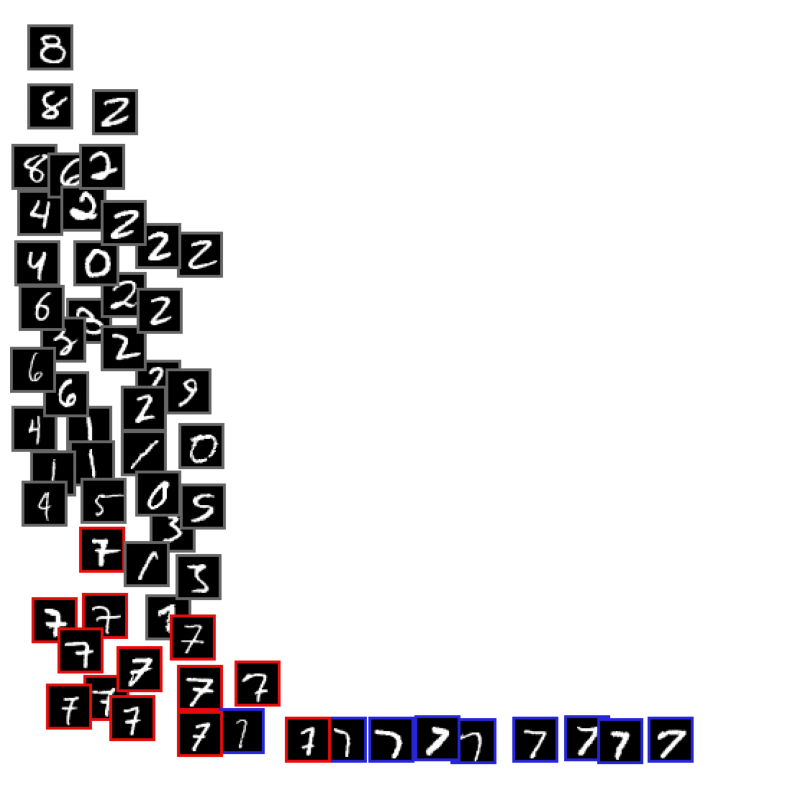

877
151
GM balanced accuracy score with hand-crafted labels :  0.8924375792033428
Epoch: 50 	Training Loss: 117.837407
         	Testing Acc: 0.987847
         	Training Acc: 0.991381


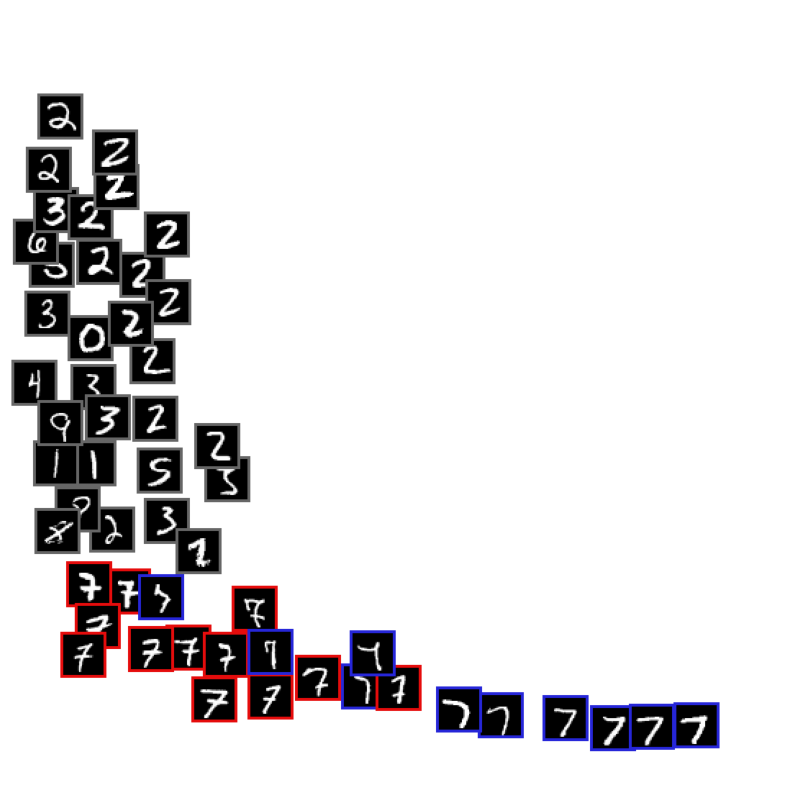

765
263
GM balanced accuracy score with hand-crafted labels :  0.889851697092167
Epoch: 51 	Training Loss: 124.759407
         	Testing Acc: 0.990451
         	Training Acc: 0.991784


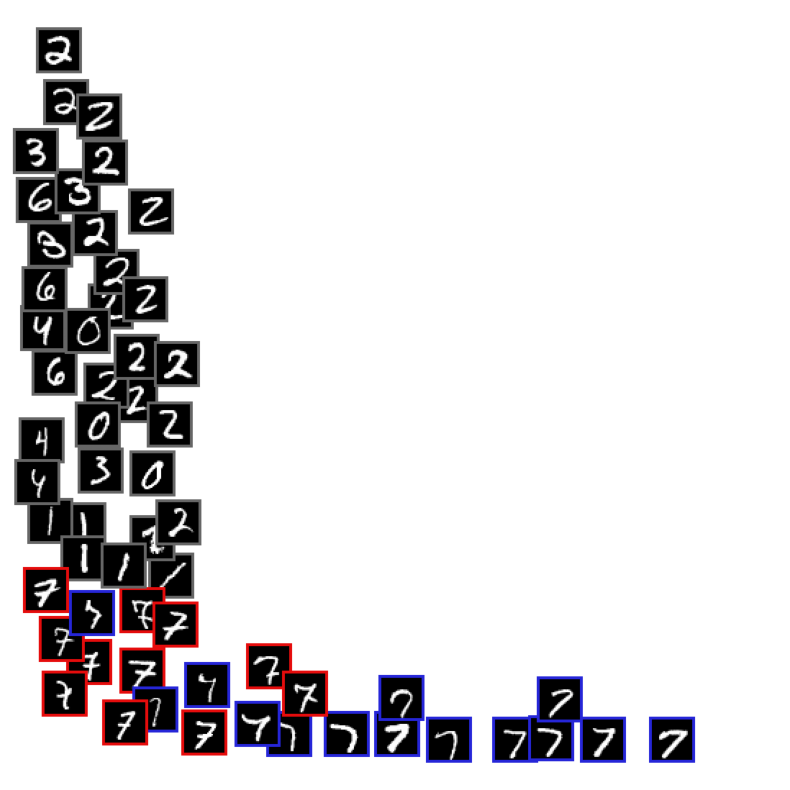

812
216
GM balanced accuracy score with hand-crafted labels :  0.9212419084152481
Epoch: 52 	Training Loss: 117.164257
         	Testing Acc: 0.996528
         	Training Acc: 0.992108


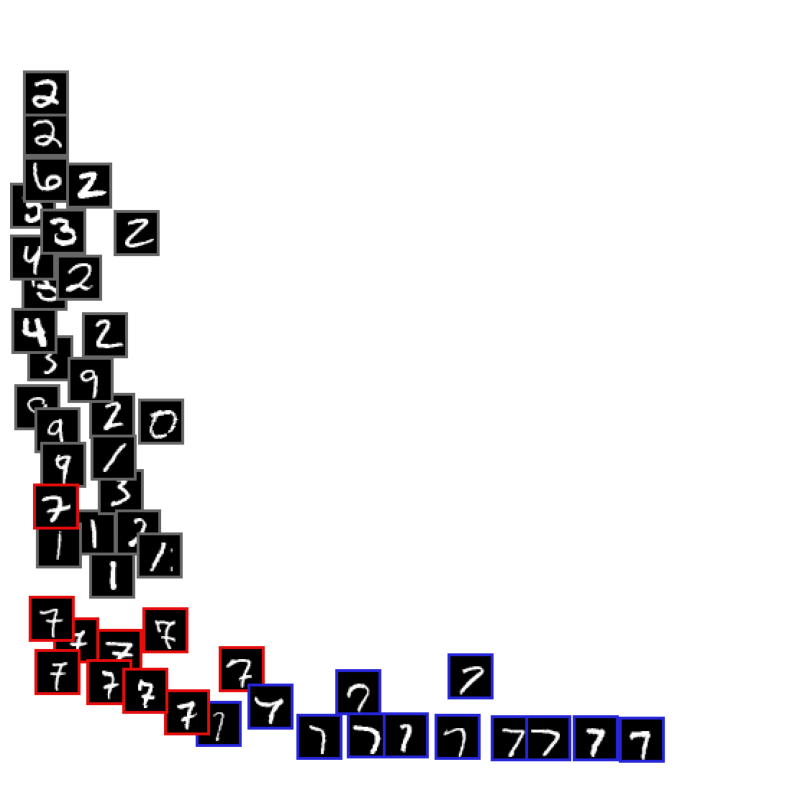

802
226
GM balanced accuracy score with hand-crafted labels :  0.928228927629551
Epoch: 53 	Training Loss: 114.326082
         	Testing Acc: 0.988281
         	Training Acc: 0.992253


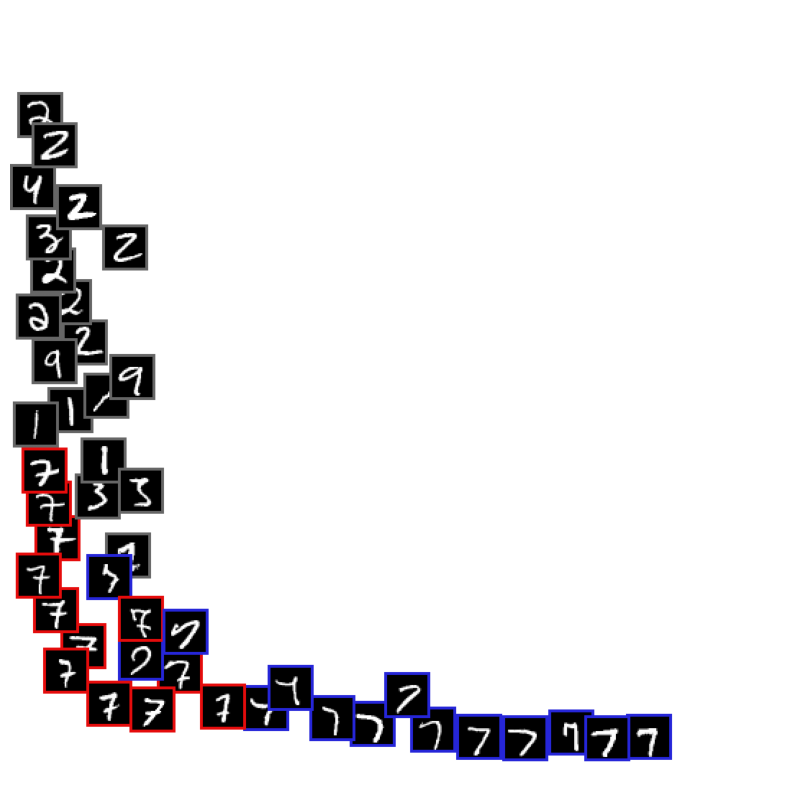

759
269
GM balanced accuracy score with hand-crafted labels :  0.908466623283214
Epoch: 54 	Training Loss: 116.811672
         	Testing Acc: 0.993490
         	Training Acc: 0.990814


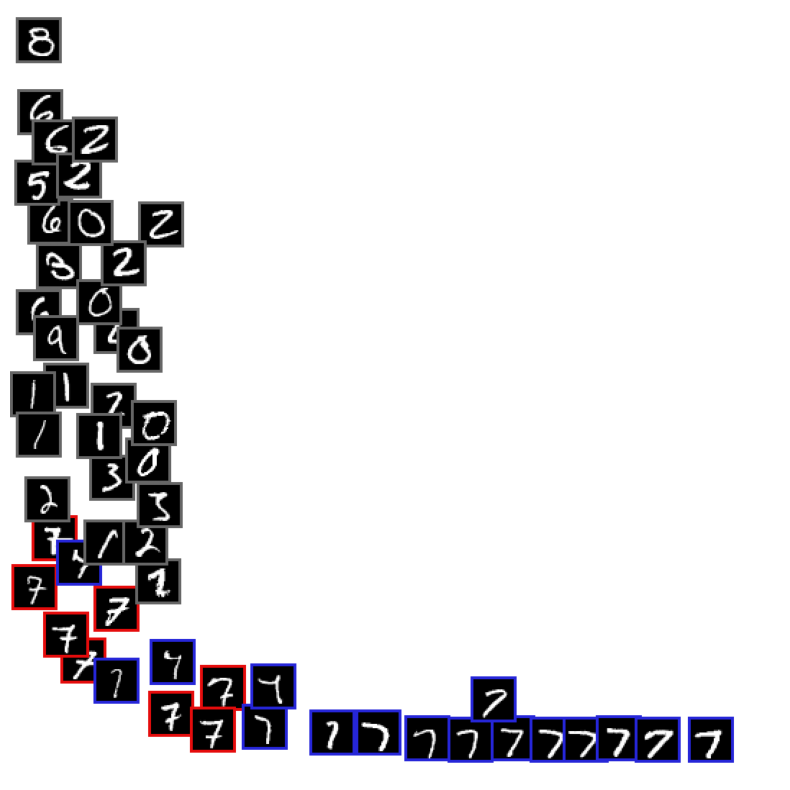

795
233
GM balanced accuracy score with hand-crafted labels :  0.9081241223413364


In [ ]:
import datetime

# number of epochs to train the model
n_epochs = 75
lr = 0.00001 # 0.00005
batch_size = 256

for run in range(0, 3):
  begin_time = datetime.datetime.now()

  # build model
  conditional_classifier_model = SimpleConditionalConvNet(nc, nz, n_clusters).float().cuda()
  conditional_classifier_model.eval()

  train_data = MyDataset(X_train, y_train, test=True)
  test_data = MyDataset(X_test, y_test, test=True)
  train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size)
  test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size)
  with torch.no_grad() :
    X_train_latent = torch.zeros((0, nz), device="cuda")
    for data in train_loader:
        images, _, _ = data
        _, _, encoded_vectors = conditional_classifier_model.forward(images)
        X_train_latent = torch.cat((X_train_latent, encoded_vectors), dim=0)
    X_test_latent = torch.zeros((0, nz), device="cuda")
    for data in test_loader:
        images, _, _ = data
        _, _, encoded_vectors = conditional_classifier_model.forward(images)
        X_test_latent = torch.cat((X_test_latent, encoded_vectors), dim=0)

  # get positive representations
  scaler = PytorchRobustScaler().fit(X_train_latent[train_positive_labels_indices])
  X_train_latent = scaler.transform(X_train_latent)
  X_test_latent = scaler.transform(X_test_latent)

  # KM training
  km = SoftSKKMeans(n_clusters=2).fit(X_train_latent[train_positive_labels_indices])
  barycenters = km.centroids.cpu().numpy()
  y_train_clustering_pseudo_labels = predict_proba_from_barycenters(X_train_latent.cpu().numpy(), barycenters)
  y_test_clustering_pseudo_labels = predict_proba_from_barycenters(X_train_latent.cpu().numpy(), barycenters)

  initial_clustering_accuracies = (
            max(balanced_accuracy_score(y_ground_truth, np.argmax(y_test_clustering_pseudo_labels[test_positive_labels_indices][:len(y_ground_truth)], 1)),
            balanced_accuracy_score(1-y_ground_truth, np.argmax(y_test_clustering_pseudo_labels[test_positive_labels_indices][:len(y_ground_truth)], 1))))
  print("Initial clustering accuracy : ", initial_clustering_accuracies)

  # dataloaders
  train_data = MyDataset(X_train, y_train_binary, y_train_clustering_pseudo_labels)
  test_data = MyDataset(X_test, y_test_binary, test=True)
  # prepare data loaders
  train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
  test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size)

  # specify loss function
  list_of_parameters = []
  list_of_parameters.extend(conditional_classifier_model.parameters())
  optimizer = torch.optim.Adam(list_of_parameters, lr=lr)

  train_losses = []
  test_losses = []
  test_accuracies = []
  train_accuracies = []
  clustering_stabilities = []
  clustering_accuracies = [initial_clustering_accuracies]

  for epoch in range(1, n_epochs+1):
      # monitor training loss
      train_loss = 0.0
      test_loss = 0.0

      ###################
      # train the model #
      ###################
      conditional_classifier_model.train()
      train_accuracy=0.0
      for data in train_loader:
          # _ stands in for labels, here no need to flatten images
          images, _, labels, cluster_pseudo_labels = data
          # clear the gradients of all optimized variables
          optimizer.zero_grad()
          # forward pass: compute predicted outputs by passing inputs to the model
          y_conditional_pred, y_clustering_pred, encoded_vectors = conditional_classifier_model.forward(images)
          y_pred = (y_clustering_pred*y_conditional_pred).sum(1)
          loss = compute_ucsl_loss(y_conditional_pred, y_clustering_pred, labels, cluster_pseudo_labels, alpha=1-max(1, epoch/50))
          # backward pass: compute gradient of the loss with respect to model parameters
          loss.backward()
          # perform a single optimization step (parameter update)
          optimizer.step()
          # update running training loss
          train_loss += loss.item()*images.size(0)
          train_accuracy += ((y_pred>0.5)==labels).float().mean()

      ###################
      # evaluate the model #
      ###################
      conditional_classifier_model.eval()
      test_accuracy = 0
      with torch.no_grad():
        for data in test_loader:
          # _ stands in for labels, here no need to flatten images
          images, _, labels = data
          # forward pass: compute predicted outputs by passing inputs to the model
          y_conditional_pred, y_clustering_pred, encoded_vectors = conditional_classifier_model.forward(images)
          y_pred = (y_clustering_pred*y_conditional_pred).sum(1)
          # update running training loss
          test_accuracy += ((y_pred>0.5)==labels).float().mean()

      # print avg training statistics
      train_loss = train_loss/len(train_loader)
      test_accuracy = test_accuracy/len(test_loader)
      train_accuracy = train_accuracy/len(train_loader)
      #
      train_losses.append(train_loss)
      test_accuracies.append(test_accuracy.view(-1).cpu().detach().numpy())
      train_accuracies.append(train_accuracy.view(-1).cpu().detach().numpy())
      print('Epoch: {} \tTraining Loss: {:.6f}'.format(
          epoch,
          train_loss
          ))
      print('         \tTesting Acc: {:.6f}'.format(
          test_accuracy
          ))
      print('         \tTraining Acc: {:.6f}'.format(
          train_accuracy
          ))

      with torch.no_grad():
          train_data = MyDataset(X_train, y_train, test=True)
          test_data = MyDataset(X_test, y_test, test=True)
          train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size)
          test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size)
          with torch.no_grad() :
            X_train_latent = torch.zeros((0, nz), device="cuda")
            for data in train_loader:
                images, _, _ = data
                _, _, encoded_vectors = conditional_classifier_model.forward(images)
                X_train_latent = torch.cat((X_train_latent, encoded_vectors), dim=0)
            X_test_latent = torch.zeros((0, nz), device="cuda")
            for data in test_loader:
                images, _, _ = data
                _, _, encoded_vectors = conditional_classifier_model.forward(images)
                X_test_latent = torch.cat((X_test_latent, encoded_vectors), dim=0)

      # get positive representations
      scaler = PytorchRobustScaler().fit(X_train_latent[train_positive_labels_indices])
      X_train_latent = scaler.transform(X_train_latent)
      X_test_latent = scaler.transform(X_test_latent)

      # KM training
      old_barycenters = np.copy(barycenters)
      km = SoftSKKMeans(n_clusters=2).fit(X_train_latent[train_positive_labels_indices])
      barycenters = km.centroids.cpu().numpy()
      barycenters_similarity = predict_proba_from_barycenters(barycenters, old_barycenters)
      permutation_index = reassign_barycenters(barycenters_similarity)
      barycenters = barycenters[permutation_index]
      y_train_clustering_pseudo_labels = predict_proba_from_barycenters(X_train_latent.cpu().numpy(), barycenters)
      y_test_clustering_pseudo_labels = predict_proba_from_barycenters(X_test_latent.cpu().numpy(), barycenters)

      # pca
      pca = PCA().fit(X_train_latent[train_positive_labels_indices].cpu().numpy())
      X_test_latent_pca = pca.transform(X_test_latent.cpu().numpy())
      create_visualization(X_test_latent.cpu().numpy(), X_test, y_test, y_ground_truth, np.argmax(y_test_clustering_pseudo_labels, 1))

      for label in [0, 1] :
        print(np.sum(np.argmax(y_test_clustering_pseudo_labels[test_positive_labels_indices], 1)==label))

      print("GM balanced accuracy score with hand-crafted labels : ",
            max(balanced_accuracy_score(y_ground_truth, np.argmax(y_test_clustering_pseudo_labels[test_positive_labels_indices][:len(y_ground_truth)], 1)),
            balanced_accuracy_score(1-y_ground_truth, np.argmax(y_test_clustering_pseudo_labels[test_positive_labels_indices][:len(y_ground_truth)], 1))))

      # train dataloaders
      train_data = MyDataset(X_train, y_train_binary, y_train_clustering_pseudo_labels)
      train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
      # test dataloaders
      test_data = MyDataset(X_test, y_test_binary)
      test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size)

  print(datetime.datetime.now() - begin_time)


  print('------------------------------------------------------------------')


In [ ]:
# Deep UCSL w SK
values = [0.938, 0.928, 0.986]

print(np.mean(values))
print(np.std(values))

In [ ]:
print(datetime.datetime.now() - begin_time)
# 0:27:46.132543